In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.patches import Ellipse, Circle

from itertools import islice
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torchvision
from mpl_toolkits.mplot3d import Axes3D

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)


steps = 10000

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

device = "mps" if torch.backends.mps.is_available() else "cpu"
print("device is:", device)

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

#torch.set_default_tensor_type(torch.DoubleTensor)


class BioLinear2D(nn.Module):

    def __init__(self, in_dim, out_dim, in_fold=1, out_fold=1, out_ring=False):
        super(BioLinear2D, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.linear = nn.Linear(in_dim, out_dim)
        self.in_fold = in_fold
        self.out_fold = out_fold
        assert in_dim % in_fold == 0
        assert out_dim % out_fold == 0

        #compute in_cor, shape: (in_dim_sqrt, in_dim_sqrt)
        in_dim_fold = int(in_dim/in_fold)
        out_dim_fold = int(out_dim/out_fold)
        in_dim_sqrt = int(np.sqrt(in_dim_fold))
        out_dim_sqrt = int(np.sqrt(out_dim_fold))
        x = np.linspace(1/(2*in_dim_sqrt), 1-1/(2*in_dim_sqrt), num=in_dim_sqrt)
        X, Y = np.meshgrid(x, x)
        self.in_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)

        # compute out_cor, shape: (out_dim_sqrt, out_dim_sqrt)
        if out_ring:
            thetas = np.linspace(1/(2*out_dim_fold)*2*np.pi, (1-1/(2*out_dim_fold))*2*np.pi, num=out_dim_fold)
            self.out_coordinates = 0.5+torch.tensor(np.transpose(np.array([np.cos(thetas), np.sin(thetas)]))/4, dtype=torch.float)
        else:
            x = np.linspace(1/(2*out_dim_sqrt), 1-1/(2*out_dim_sqrt), num=out_dim_sqrt)
            X, Y = np.meshgrid(x, x)
            self.out_coordinates = torch.tensor(np.transpose(np.array([X.reshape(-1,), Y.reshape(-1,)])), dtype=torch.float)


    def forward(self, x):
        return self.linear(x)


class BioMLP2D(nn.Module):
    def __init__(self, in_dim=2, out_dim=2, w=2, depth=2, shp=None, token_embedding=False, embedding_size=None):
        super(BioMLP2D, self).__init__()
        if shp == None:
            shp = [in_dim] + [w]*(depth-1) + [out_dim]
            self.in_dim = in_dim
            self.out_dim = out_dim
            self.depth = depth

        else:
            self.in_dim = shp[0]
            self.out_dim = shp[-1]
            self.depth = len(shp) - 1
        linear_list = []
        for i in range(self.depth):
            if i == 0:
                # for modular addition
                #linear_list.append(BioLinear(shp[i], shp[i+1], in_fold=2))
                # for regression
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1).to(device))
            elif i == self.depth - 1:
                linear_list.append(BioLinear2D(shp[i], shp[i+1], in_fold=1, out_ring=True).to(device))
            else:
                linear_list.append(BioLinear2D(shp[i], shp[i+1]).to(device))
        self.linears = nn.ModuleList(linear_list)


        if token_embedding == True:
            # embedding size: number of tokens * embedding dimension
            self.embedding = torch.nn.Parameter(torch.normal(0,1,size=embedding_size)).to(device)

        self.shp = shp
        # parameters for the bio-inspired trick
        self.l0 = 0.5 # distance between two nearby layers
        self.in_perm = nn.Parameter(torch.tensor(np.arange(int(self.in_dim/self.linears[0].in_fold)), dtype=torch.float))
        self.out_perm = nn.Parameter(torch.tensor(np.arange(int(self.out_dim/self.linears[-1].out_fold)), dtype=torch.float))
        self.top_k = 30
        self.token_embedding = token_embedding

    def forward(self, x):
        shp = x.shape
        x = x.reshape(shp[0],-1)
        shp = x.shape
        in_fold = self.linears[0].in_fold
        x = x.reshape(shp[0], in_fold, int(shp[1]/in_fold))
        x = x[:,:,self.in_perm.long()]
        x = x.reshape(shp[0], shp[1])
        f = torch.nn.SiLU()
        for i in range(self.depth-1):
            x = f(self.linears[i](x))
        x = self.linears[-1](x)

        out_perm_inv = torch.zeros(self.out_dim, dtype=torch.long)
        out_perm_inv[self.out_perm.long()] = torch.arange(self.out_dim)
        x = x[:,out_perm_inv]
        #x = x[:,self.out_perm]

        return x

    def get_linear_layers(self):
        return self.linears

    def get_cc(self, weight_factor=2.0, bias_penalize=True, no_penalize_last=False):
        # compute connection cost
        cc = 0
        num_linear = len(self.linears)
        for i in range(num_linear):
            if i == num_linear - 1 and no_penalize_last:
                weight_factor = 0.
            biolinear = self.linears[i].to(device)
            dist = torch.sum(torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0)),dim=2).to(device)
            # print("yooo")
            # print(biolinear.linear.weight.device)
            # print(dist.device)
            # print(self.l0)
            cc += torch.mean(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
            if bias_penalize == True:
                cc += torch.mean(torch.abs(biolinear.linear.bias)*(self.l0))
        if self.token_embedding:
            cc += torch.mean(torch.abs(self.embedding)*(self.l0))
            #pass
        return cc

    def swap_weight(self, weights, j, k, swap_type="out"):
        with torch.no_grad():
            if swap_type == "in":
                temp = weights[:,j].clone()
                weights[:,j] = weights[:,k].clone()
                weights[:,k] = temp
            elif swap_type == "out":
                temp = weights[j].clone()
                weights[j] = weights[k].clone()
                weights[k] = temp
            else:
                raise Exception("Swap type {} is not recognized!".format(swap_type))

    def swap_bias(self, biases, j, k):
        with torch.no_grad():
            temp = biases[j].clone()
            biases[j] = biases[k].clone()
            biases[k] = temp

    def swap(self, i, j, k):
        # in the ith layer (of neurons), swap the jth and the kth neuron.
        # Note: n layers of weights means n+1 layers of neurons.
        # (incoming, outgoing) * weights + biases are swapped.
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            return
            # for images, do not allow input_perm
            # input layer, only has outgoing weights; update in_perm
            weights = linears[i].linear.weight
            infold = linears[i].in_fold
            fold_dim = int(weights.shape[1]/infold)
            for l in range(infold):
                self.swap_weight(weights, j+fold_dim*l, k+fold_dim*l, swap_type="in")
            # change input_perm. do not allow input_perm for images
            self.swap_bias(self.in_perm, j, k)
        elif i == num_linear:
            # output layer, only has incoming weights and biases; update out_perm
            weights = linears[i-1].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights, j, k, swap_type="out")
            self.swap_bias(biases, j, k)
            # change output_perm
            self.swap_bias(self.out_perm, j, k)
        else:
            # middle layer : (incoming, outgoing) * weights, and biases
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            biases = linears[i-1].linear.bias
            self.swap_weight(weights_in, j, k, swap_type="out")
            self.swap_weight(weights_out, j, k, swap_type="in")
            self.swap_bias(biases, j, k)

    def get_top_id(self, i, top_k=20):
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i == 0:
            # input layer
            weights = linears[i].linear.weight
            score = torch.sum(torch.abs(weights), dim=0)
            in_fold = linears[0].in_fold
            #print(score.shape)
            score = torch.sum(score.reshape(in_fold, int(score.shape[0]/in_fold)), dim=0)
        elif i == num_linear:
            # output layer
            weights = linears[i-1].linear.weight
            score = torch.sum(torch.abs(weights), dim=1)
        else:
            weights_in = linears[i-1].linear.weight
            weights_out = linears[i].linear.weight
            score = torch.sum(torch.abs(weights_out), dim=0) + torch.sum(torch.abs(weights_in), dim=1)
        #print(score.shape)
        top_index = torch.flip(torch.argsort(score),[0])[:top_k]
        return top_index, score

    def relocate_ij(self, i, j):
        # In the ith layer (of neurons), relocate the jth neuron
        linears = self.get_linear_layers()
        num_linear = len(linears)
        if i < num_linear:
            num_neuron = int(linears[i].linear.weight.shape[1]/linears[i].in_fold)
        else:
            num_neuron = linears[i-1].linear.weight.shape[0]
        ccs = []
        for k in range(num_neuron):
            self.swap(i,j,k)
            ccs.append(self.get_cc())
            self.swap(i,j,k)
        k = torch.argmin(torch.stack(ccs))
        self.swap(i,j,k)

    def relocate_i(self, i):
        # Relocate neurons in the ith layer
        top_id = self.get_top_id(i, top_k=self.top_k)
        for j in top_id[0]:
            self.relocate_ij(i,j)

    def relocate(self):
        # Relocate neurons in the whole model
        linears = self.get_linear_layers()
        num_linear = len(linears)
        for i in range(num_linear+1):
            self.relocate_i(i)



device is: mps


In [55]:
train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)
data_size = 60000
train = torch.utils.data.Subset(train, range(data_size))
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

# Creating slices for circles

In [56]:
import torchvision
import torch

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)

# Define the digits with circles
digits_with_circles = [0, 6, 8, 9]

# Filter out the specific digits
filtered_dataset = [(image, label) for image, label in train_dataset if label in digits_with_circles]

# You can now use filtered_dataset for your purposes
# For example, to create a DataLoader:
circle_loader = torch.utils.data.DataLoader(filtered_dataset, batch_size=64, shuffle=True)


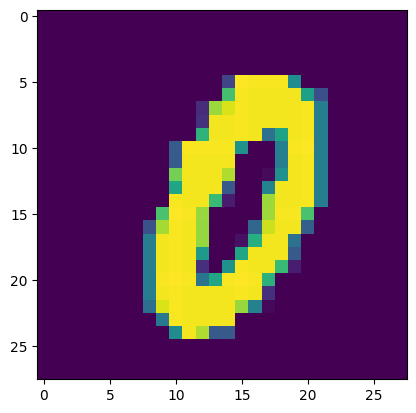

In [57]:
plt.imshow(filtered_dataset[11][0].squeeze())  #0 11 

# Training 5 Models for comparison

In [58]:
# train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
# test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)
# train_loader = torch.utils.data.DataLoader(train, batch_size=50, shuffle=True)

def accuracy(network, dataset, device, N=2000, batch_size=50):
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    correct = 0
    total = 0
    for x, labels in islice(dataset_loader, N // batch_size):
        #print(x.shape)
        logits = network(x.to(device))
        predicted_labels = torch.argmax(logits, dim=1)
        correct += torch.sum(predicted_labels == labels.to(device))
        total += x.size(0)
    return correct / total

def loss_f(network, dataset, device, N=2000, batch_size=50):
    dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss = 0
    total = 0
    for x, labels in islice(dataset_loader, N // batch_size):
        logits = network(x.to(device))
        loss += torch.sum((logits-torch.eye(10,)[labels].to(device))**2)
        total += x.size(0)
    return loss / total

train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)

data_size = 60000
train = torch.utils.data.Subset(train, range(data_size))
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

def L2(model):
    L2_ = 0.
    for p in mlp.parameters():
        L2_ += torch.sum(p**2)
    return L2_

def rescale(model, alpha):
    for p in mlp.parameters():
        p.data = alpha * p.data


width = 200
mlp = BioMLP2D(shp=(784,100,100,10))
mlp.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(mlp.parameters(), lr=1e-3, weight_decay=0.0)

one_hots = torch.eye(10, 10).to(device)

mlp.eval()
print("Initial accuracy: {0:.4f}".format(accuracy(mlp, test, device)))

test_accuracies = []
train_accuracies = []

step = 0
mlp.train()
pbar = tqdm(islice(cycle(train_loader), steps), total=steps)

best_train_loss = 1e4
best_test_loss = 1e4
best_train_acc = 0.
best_test_acc = 0.

log = 200
# lamb = 0.01
# swap_log = 500
plot_log = 500

train_type = 5

#train_type = 1; #no L1
# train_type = 2; #L1
# train_type = 3: L1 + Local
# train_type = 4: L1 + Swap
# train_type = 5: L1 + Local + Swap
lamb = 0 if train_type==1 else 0.01
swap_log = 200 if train_type >= 4 else float('inf')
weight_factor = 2. if train_type == 3 or train_type == 5 else 0.

for x, label in pbar:

    if step == int(steps/4):
        lamb *= 10
    elif step == int(steps/2):
        lamb *= 10

    mlp.train()
    optimizer.zero_grad()
    loss_train = loss_fn(mlp(x.to(device)), one_hots[label])
    cc = mlp.get_cc(weight_factor, no_penalize_last=True)
    total_loss = loss_train + lamb*cc
    total_loss.backward()
    optimizer.step()

    if step % log == 0:
        with torch.no_grad():
            mlp.eval()
            train_acc = accuracy(mlp, train, device).item()
            test_acc = accuracy(mlp, test, device).item()
            train_loss = loss_f(mlp, train, device).item()
            test_loss = loss_f(mlp, test, device).item()

            if train_acc > best_train_acc:
                best_train_acc = train_acc
            if test_acc > best_test_acc:
                best_test_acc = test_acc
            if train_loss < best_train_loss:
                best_train_loss = train_loss
            if test_loss < best_test_loss:
                best_test_loss = test_loss
            mlp.train()
            pbar.set_description("{:3.3f} | {:3.3f} | {:3.3f} | {:3.3f} | {:3.3f} ".format(train_acc, test_acc, train_loss, test_loss, cc))
    step += 1

    if step % swap_log == 0:
        mlp.relocate()

mlp.to("cpu")
torch.save(mlp.state_dict(), 'fivemodels/bimt.pt')

Initial accuracy: 0.1060


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/zephyr/anaconda3/envs/modmi/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning:

The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391829313/work/aten/src/ATen/mps/MPSFallback.mm:13.)

  0%|          | 0/10000 [00:02<?, ?it/s]


KeyboardInterrupt: 

## Load the model

In [ ]:
mlp = BioMLP2D(shp=(784,100,100,10)).to("cpu")
mlp.load_state_dict(torch.load('fivemodels/bimt.pt'))

<All keys matched successfully>

# Function for calculating sparsity of a model


# Activation Patch 

Returns circuit from model, dataset 

## Run one example again

## Index Checking (if all neurons actually stay)

In [ ]:
def extract_activations(layer, input, output):
    return output

activations = []

def hook_fn(module, input, output):
    activations.append(output)

hooks = []

def measure_improvement(patched_logits, original_logits):
    # Compute L2 difference
    difference_L2 = torch.norm(patched_logits - original_logits, p=2).item()
    return difference_L2

def patch_neuron(activation, neuron_idx, new_value):
    patched_activation = activation.clone()
    # print("To be patched: ", patched_activation[0, neuron_idx])
    # print("patched to:", new_value)
    patched_activation[0, neuron_idx] = new_value
    return patched_activation

def circuit_discovery(model, clean_tensor, corr_tensor):

    # Attach hooks to all BioLinear2D layers
    for layer in model.get_linear_layers():
        hooks.append(layer.register_forward_hook(hook_fn))

    model.eval() 
    original_output = model(clean_tensor)
    clean_activations = activations.copy()  # Store activations after passing the clean tensor
    activations.clear()
    # print(clean_activations)
    model(corr_tensor)
    corrupted_activations = activations  # Store activations after passing the corrupted tensor
    # print(corrupted_activations)

    # Clear the hooks
    for hook in hooks:
        hook.remove()

    improvements = []

    # Iterate through layers
    for layer_idx, (clean_act, corrupted_act) in enumerate(zip(clean_activations, corrupted_activations)):
        num_neurons = clean_act.shape[1]
        
        for neuron_idx in range(num_neurons):
            # Patch the neuron in the corrupted activations
            patched_act = patch_neuron(corrupted_act, neuron_idx, clean_act[0, neuron_idx])

            # Store the patched activations and keep others as-is
            current_activations = [a.clone() for a in corrupted_activations]
            current_activations[layer_idx] = patched_act
            model.eval() 

            for inn_idx, sub_layer in enumerate(model.get_linear_layers()[layer_idx+1:]):
                current_activations[layer_idx+inn_idx+1] = sub_layer(current_activations[layer_idx+inn_idx])

            improvement = measure_improvement(current_activations[-1], original_output)  # Implement measure_improvement as required
            improvements.append((layer_idx, neuron_idx, improvement))

    sorted_neurons = sorted(improvements, key=lambda x: x[2], reverse=False)
    return sorted_neurons


In [ ]:
clean_tensor = filtered_dataset[11][0].unsqueeze(0)
gaussian = np.random.normal(0, 10**0.5, (clean_tensor.shape[2],clean_tensor.shape[3])) 
gaussian_tensor = torch.tensor(gaussian, dtype=torch.float32)
corr_tensor = clean_tensor + gaussian_tensor

In [ ]:
circuit_discovery(mlp, clean_tensor, corr_tensor)

[(2, 7, 1.3116344213485718),
 (2, 4, 1.6237123012542725),
 (2, 3, 1.772291660308838),
 (2, 5, 1.7740219831466675),
 (2, 8, 1.7770758867263794),
 (2, 2, 1.7771720886230469),
 (2, 1, 1.7774027585983276),
 (2, 6, 1.7776983976364136),
 (2, 0, 1.8072999715805054),
 (2, 9, 1.990830898284912),
 (1, 55, 4.285872459411621),
 (1, 52, 8.786961555480957),
 (1, 36, 9.278036117553711),
 (1, 25, 9.364168167114258),
 (1, 74, 9.395708084106445),
 (1, 34, 9.41550350189209),
 (1, 24, 9.418092727661133),
 (1, 42, 9.435508728027344),
 (1, 63, 9.43554401397705),
 (1, 76, 9.447188377380371),
 (1, 84, 9.447188377380371),
 (1, 97, 9.447188377380371),
 (1, 2, 9.447189331054688),
 (1, 5, 9.447189331054688),
 (1, 9, 9.447189331054688),
 (1, 16, 9.447189331054688),
 (1, 17, 9.447189331054688),
 (1, 20, 9.447189331054688),
 (1, 27, 9.447189331054688),
 (1, 29, 9.447189331054688),
 (1, 40, 9.447189331054688),
 (1, 43, 9.447189331054688),
 (1, 49, 9.447189331054688),
 (1, 57, 9.447189331054688),
 (1, 64, 9.4471893310

## Average over the dataset

In [ ]:
len(filtered_dataset)

23641

In [ ]:
from collections import defaultdict
from itertools import groupby
from operator import itemgetter
combined_list = []

value_dict = defaultdict(lambda: {'sum': 0, 'count': 0})

for i in range(len(filtered_dataset)):
    clean_tensor = filtered_dataset[i][0].unsqueeze(0)
    gaussian = np.random.normal(0, 10**0.5, (clean_tensor.shape[2],clean_tensor.shape[3])) 
    gaussian_tensor = torch.tensor(gaussian, dtype=torch.float32)
    corr_tensor = clean_tensor + gaussian_tensor
    sorted_neurons =  circuit_discovery(mlp, clean_tensor, corr_tensor)
    for layer, neuron, value in sorted_neurons:
        value_dict[(layer, neuron)]['sum'] += value
        value_dict[(layer, neuron)]['count'] += 1
    # combined_list += sorted_neurons
    # sorted_tuples = sorted(sorted_neurons, key=itemgetter(0, 2))

    # grouped_tuples = {k: list(g) for k, g in groupby(sorted_tuples, key=itemgetter(0))}
    # print(grouped_tuples)
    # top_10_per_group = {k: [x[1] for x in v] for k, v in grouped_tuples.items()}

    # # Output the result
    # for key, value in top_10_per_group.items():
    #     print(f'Group {key}: {value}')




# Populating the dictionary with data from the combined list


# Calculating the average for each neuron and layer
average_values = {}
for key, data in value_dict.items():
    average = data['sum'] / data['count']
    average_values[key] = average

average_values.items() 

dict_items([((2, 1), 2.803486992497996), ((2, 0), 2.81072087146789), ((2, 9), 2.7954266240680754), ((2, 3), 2.7943424926479428), ((2, 6), 2.7948849699468834), ((2, 2), 2.809395848972322), ((2, 8), 2.817126888723955), ((2, 4), 2.808672982903585), ((2, 5), 2.8069206885780753), ((2, 7), 2.788440056866896), ((1, 74), 9.479599184279142), ((1, 24), 9.490547362915287), ((1, 34), 9.492595313693721), ((1, 36), 9.602202605093844), ((1, 66), 9.498942944564915), ((1, 42), 9.531687613081385), ((0, 75), 13.290068485607659), ((1, 6), 9.491547017294936), ((1, 47), 9.491547127478185), ((1, 48), 9.491547030833997), ((1, 79), 9.491547031096207), ((1, 18), 9.491546993126326), ((1, 26), 9.491546969119074), ((1, 40), 9.491547039320492), ((1, 49), 9.491547029926352), ((1, 54), 9.491547008400001), ((1, 59), 9.491547072827778), ((1, 82), 9.491547077088674), ((1, 89), 9.491547005440065), ((1, 0), 9.491547115532548), ((1, 1), 9.49154710561903), ((1, 3), 9.491547074769134), ((1, 8), 9.491547065884282), ((1, 10), 

In [ ]:

data = average_values
# Separate the dictionary for each layer and sort according to the logit value
layer_dict = {}
for (layer, neuron), logit in data.items():
    if layer not in layer_dict:
        layer_dict[layer] = []
    layer_dict[layer].append(((layer, neuron), logit))

# Sort each layer's list by logit value in descending order
for layer in layer_dict:
    layer_dict[layer].sort(key=lambda x: x[1], reverse=True)

# Function to get top N elements from each layer
def get_top_n_from_each_layer(layer_dict, n):
    top_n = {}
    for layer in layer_dict:
        top_n[layer] = layer_dict[layer][:n]
    return top_n

# Example: Get top 5 elements from each layer
top_5 = get_top_n_from_each_layer(layer_dict, 30)
print(top_5)


{2: [((2, 8), 2.817126888723955), ((2, 0), 2.81072087146789), ((2, 2), 2.809395848972322), ((2, 4), 2.808672982903585), ((2, 5), 2.8069206885780753), ((2, 1), 2.803486992497996), ((2, 9), 2.7954266240680754), ((2, 6), 2.7948849699468834), ((2, 3), 2.7943424926479428), ((2, 7), 2.788440056866896)], 1: [((1, 55), 9.879716816108232), ((1, 52), 9.79909339380125), ((1, 36), 9.602202605093844), ((1, 33), 9.559267958682643), ((1, 42), 9.531687613081385), ((1, 25), 9.516837409101239), ((1, 46), 9.503512513299192), ((1, 63), 9.502557153947048), ((1, 66), 9.498942944564915), ((1, 34), 9.492595313693721), ((1, 64), 9.491547178926618), ((1, 62), 9.491547170031682), ((1, 41), 9.491547157193525), ((1, 47), 9.491547127478185), ((1, 78), 9.491547126459604), ((1, 99), 9.491547122168454), ((1, 0), 9.491547115532548), ((1, 21), 9.491547112597825), ((1, 53), 9.491547111352332), ((1, 69), 9.491547109920267), ((1, 1), 9.49154710561903), ((1, 72), 9.49154710234646), ((1, 37), 9.491547100152982), ((1, 44), 9.

In [ ]:
import plotly.express as px
for key, val in layer_dict.items():
    # print(val)
    y_values = [t[1] for t in val]
    x_values = [t[0][1] for t in val]
    # print(x_values)
    print(np.mean(y_values))
    print(y_values)

    colors = ['Potentially Part of Circuit' if y < np.mean(y_values)-0.05 else 'Not relevant to task' for y in y_values]
    if key == 2:
        colors = ['Potentially Part of Circuit' if y <= np.mean(y_values)+0.5 else 'Not relevant to task' for y in y_values]
    if key == 1:
        colors = ['Potentially Part of Circuit' if y <= np.mean(y_values) else 'Not relevant to task' for y in y_values]
    fig = px.scatter(x = x_values, y=y_values, color=colors) #, size=[0.001]*len(x_values))
    fig.update_traces(marker=dict(
        size=15,
        line=dict(
            width=1,
            color='DarkSlateGrey'
        )
    ))
    fig.update_xaxes(title_text='Neuron (i)')
    fig.update_yaxes(title_text='Logit Difference (L_corr --> L_clean)')
    fig.update_layout(width=1000, height=700)
    fig.show()
    # break

2.802941841667362
[2.817126888723955, 2.81072087146789, 2.809395848972322, 2.808672982903585, 2.8069206885780753, 2.803486992497996, 2.7954266240680754, 2.7948849699468834, 2.7943424926479428, 2.788440056866896]


9.501127008460136
[9.879716816108232, 9.79909339380125, 9.602202605093844, 9.559267958682643, 9.531687613081385, 9.516837409101239, 9.503512513299192, 9.502557153947048, 9.498942944564915, 9.492595313693721, 9.491547178926618, 9.491547170031682, 9.491547157193525, 9.491547127478185, 9.491547126459604, 9.491547122168454, 9.491547115532548, 9.491547112597825, 9.491547111352332, 9.491547109920267, 9.49154710561903, 9.49154710234646, 9.491547100152982, 9.49154709594251, 9.491547089654537, 9.491547088086325, 9.49154708697698, 9.491547084526333, 9.491547083598517, 9.491547081354613, 9.491547079705722, 9.491547079614957, 9.491547079342663, 9.491547078248445, 9.491547077088674, 9.491547077023123, 9.491547076211283, 9.491547075142277, 9.491547074769134, 9.491547073321941, 9.49154707323622, 9.491547072827778, 9.491547072368913, 9.491547071723474, 9.491547070397303, 9.491547065884282, 9.491547064184966, 9.49154705860294, 9.49154705858277, 9.491547058169287, 9.491547057957503, 9.491547055874957, 9

13.265462168473228
[13.446517420533112, 13.425920663864842, 13.350060706856459, 13.337842123010558, 13.334888569136107, 13.319442853422961, 13.306531376677526, 13.303670268359108, 13.302869902090354, 13.30131105634193, 13.299866278377978, 13.299816233671779, 13.299670251894963, 13.290068485607659, 13.282902411915144, 13.278232956229115, 13.267595782598049, 13.26747662646633, 13.264101137753283, 13.260985190803531, 13.260321646665318, 13.25937895147355, 13.259378951130662, 13.259378947631179, 13.259378945745292, 13.259378942608869, 13.25937893818157, 13.259378937102479, 13.259378936194834, 13.25937893429886, 13.2593789316566, 13.259378931646514, 13.259378931061587, 13.259378930264875, 13.259378929548843, 13.259378928621027, 13.259378928399158, 13.259378927118368, 13.259378926583864, 13.259378926341826, 13.259378925817407, 13.259378925585454, 13.259378925424095, 13.259378924637467, 13.259378921571638, 13.259378921490958, 13.259378921299344, 13.259378921178325, 13.259378920411867, 13.2593

In [ ]:
# sorted_tuples = sorted(sorted_neurons, key=itemgetter(0, 2))

# Group the tuples by the first value
# grouped_tuples = {k: list(g) for k, g in groupby(sorted_tuples, key=itemgetter(0))}

# Create a new figure
# plt.figure(figsize=(10, 6), dpi=80)


# Plot a graph for each group
for key, group in grouped_tuples.items():
    x_values = [t[1] for t in group]
    y_values = [t[2] for t in group]
    
    colors = ['Potentially Part of Circuit' if y < np.mean(y_values)-0.1 else 'Not relevant to task' for y in y_values]
    if key == 2:
        colors = ['Potentially Part of Circuit' if y <= np.mean(y_values)+0.5 else 'Not relevant to task' for y in y_values]
    if key == 1:
        colors = ['Potentially Part of Circuit' if y <= np.mean(y_values) else 'Not relevant to task' for y in y_values]
    fig = px.scatter(x = x_values, y=y_values, color=colors) #, size=[0.001]*len(x_values))
    fig.update_traces(marker=dict(
        size=15,
        line=dict(
            width=1,
            color='DarkSlateGrey'
        )
    ))
    fig.update_xaxes(title_text='Neuron (i)')
    fig.update_yaxes(title_text='Logit Difference (L_corr --> L_clean)')
    fig.update_layout(width=1000, height=700)
    fig.show()

# Act Patching with key difference

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)

# Create datasets for each class
class_3_dataset = [(image, label) for image, label in train_dataset if label == 3]
class_5_dataset = [(image, label) for image, label in train_dataset if label == 5]
class_6_dataset = [(image, label) for image, label in train_dataset if label == 6]
class_8_dataset = [(image, label) for image, label in train_dataset if label == 8]

# Custom dataset for paired data
class PairedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __len__(self):
        # Ensure both datasets are of the same length
        return min(len(self.dataset1), len(self.dataset2))

    def __getitem__(self, idx):
        image1, _ = self.dataset1[idx % len(self.dataset1)]
        image2, _ = self.dataset2[idx % len(self.dataset2)]
        return image1, image2

# Create the paired datasets
paired_dataset_3_8 = PairedDataset(class_3_dataset, class_8_dataset)
paired_dataset_5_6 = PairedDataset(class_5_dataset, class_6_dataset)

# Combine the paired datasets
final_dataset = paired_dataset_3_8 + paired_dataset_5_6

# Create a DataLoader for the final dataset
final_loader = DataLoader(final_dataset, batch_size=1, shuffle=True)
loader_3_8 = DataLoader(paired_dataset_3_8, batch_size=1, shuffle=True)

# Example: Iterate over the DataLoader
for i, (image1, image2) in enumerate(final_loader):
    print(f"Batch {i}:")
    print("Image from Class 3/5:", image1.shape)
    print("Image from Class 6/8:", image2.shape)
    if i == 5:  # Stop after 6 iterations for demonstration
        break


Batch 0:
Image from Class 3/5: torch.Size([1, 1, 28, 28])
Image from Class 6/8: torch.Size([1, 1, 28, 28])
Batch 1:
Image from Class 3/5: torch.Size([1, 1, 28, 28])
Image from Class 6/8: torch.Size([1, 1, 28, 28])
Batch 2:
Image from Class 3/5: torch.Size([1, 1, 28, 28])
Image from Class 6/8: torch.Size([1, 1, 28, 28])
Batch 3:
Image from Class 3/5: torch.Size([1, 1, 28, 28])
Image from Class 6/8: torch.Size([1, 1, 28, 28])
Batch 4:
Image from Class 3/5: torch.Size([1, 1, 28, 28])
Image from Class 6/8: torch.Size([1, 1, 28, 28])
Batch 5:
Image from Class 3/5: torch.Size([1, 1, 28, 28])
Image from Class 6/8: torch.Size([1, 1, 28, 28])


In [105]:
loader_5_6 = DataLoader(paired_dataset_5_6, batch_size=1, shuffle=True)

In [106]:
len(loader_5_6)

5421

In [ ]:
for i, (image1, image2) in enumerate(final_loader):
    sorted_neurons =  circuit_discovery(mlp, image2, image1)
    # print(mlp(image1))
    # print(mlp(image2))
    break

from collections import defaultdict
from itertools import groupby
from operator import itemgetter
combined_list = []

value_dict = defaultdict(lambda: {'sum': 0, 'count': 0})

for i, (image1, image2) in enumerate(final_loader):
    sorted_neurons =  circuit_discovery(mlp, image2, image1)
    for layer, neuron, value in sorted_neurons:
        value_dict[(layer, neuron)]['sum'] += value
        value_dict[(layer, neuron)]['count'] += 1

average_values = {}
for key, data in value_dict.items():
    average = data['sum'] / data['count']
    average_values[key] = average

print(average_values.items())

data = average_values
# Separate the dictionary for each layer and sort according to the logit value
layer_dict = {}
for (layer, neuron), logit in data.items():
    if layer not in layer_dict:
        layer_dict[layer] = []
    layer_dict[layer].append(((layer, neuron), logit))

# Sort each layer's list by logit value in descending order
for layer in layer_dict:
    layer_dict[layer].sort(key=lambda x: x[1], reverse=True)

# Function to get top N elements from each layer
def get_top_n_from_each_layer(layer_dict, n):
    top_n = {}
    for layer in layer_dict:
        top_n[layer] = layer_dict[layer][:n]
    return top_n

# Example: Get top 5 elements from each layer
top_5 = get_top_n_from_each_layer(layer_dict, 30)
print(top_5)


import plotly.express as px
for key, val in layer_dict.items():
    # print(val)
    y_values = [t[1] for t in val]
    x_values = [t[0][1] for t in val]
    # print(x_values)
    print(np.mean(y_values))
    print(y_values)

    colors = ['Potentially Part of Circuit' if y < np.mean(y_values)-0.05 else 'Not relevant to task' for y in y_values]
    if key == 2:
        colors = ['Potentially Part of Circuit' if y <= np.mean(y_values)+0.5 else 'Not relevant to task' for y in y_values]
    if key == 1:
        colors = ['Potentially Part of Circuit' if y <= np.mean(y_values) else 'Not relevant to task' for y in y_values]
    fig = px.scatter(x = x_values, y=y_values, color=colors) #, size=[0.001]*len(x_values))
    fig.update_traces(marker=dict(
        size=15,
        line=dict(
            width=1,
            color='DarkSlateGrey'
        )
    ))
    fig.update_xaxes(title_text='Neuron (i)')
    fig.update_yaxes(title_text='Logit Difference (L_corr --> L_clean)')
    fig.update_layout(width=1000, height=700)
    fig.show()
    # break



dict_items([((2, 3), 1.2295595369598518), ((2, 5), 1.2461171522855525), ((2, 9), 1.2461332376832188), ((2, 0), 1.245974929807635), ((2, 6), 1.2420893593832079), ((2, 4), 1.2462090755818773), ((2, 1), 1.2462034376326228), ((2, 7), 1.2275964056767623), ((2, 2), 1.245853805605182), ((2, 8), 1.2473009935850536), ((1, 63), 2.0138135895296942), ((1, 36), 2.0316572814566434), ((1, 33), 2.060322425402886), ((1, 25), 2.0169895957386013), ((1, 52), 2.1144737801478213), ((1, 39), 2.031672946260046), ((1, 35), 2.031672999566861), ((1, 56), 2.03167298255056), ((1, 59), 2.031673016271179), ((1, 88), 2.0316730168343353), ((1, 5), 2.0316730005001666), ((1, 9), 2.0316730160755285), ((1, 14), 2.0316730154912213), ((1, 17), 2.031673017643376), ((1, 20), 2.031673043908127), ((1, 23), 2.0316729708987826), ((1, 28), 2.031673025974384), ((1, 32), 2.0316730051534746), ((1, 37), 2.0316730388476545), ((1, 50), 2.031672999535134), ((1, 53), 2.0316730223548505), ((1, 61), 2.031673027692935), ((1, 64), 2.031673066

2.033645371951459
[2.123653872505708, 2.1144737801478213, 2.060322425402886, 2.0438088881601417, 2.0365665571313323, 2.036197832839086, 2.035668811182484, 2.0326454521383566, 2.0316730665586324, 2.031673056601611, 2.0316730529133356, 2.031673052884252, 2.031673051062588, 2.0316730493784076, 2.031673043908127, 2.0316730388476545, 2.0316730387842004, 2.0316730342392932, 2.0316730341573317, 2.0316730330178, 2.0316730322960086, 2.031673029868885, 2.0316730295066674, 2.031673028425302, 2.0316730279308883, 2.031673027692935, 2.031673025974384, 2.0316730245757477, 2.0316730243192866, 2.031673024306067, 2.031673024276984, 2.0316730242558325, 2.031673023541973, 2.0316730223548505, 2.031673020646875, 2.0316730206019282, 2.0316730193962984, 2.0316730182752742, 2.0316730178284508, 2.031673017643376, 2.0316730174662334, 2.0316730168343353, 2.031673016673056, 2.031673016271179, 2.0316730162606036, 2.0316730160755285, 2.0316730154912213, 2.031673015353737, 2.0316730151078524, 2.031673014552628, 2.031

4.819425919810409
[4.912463129455101, 4.904847086766157, 4.893207802268695, 4.8823207980504355, 4.86924600884625, 4.849469310176381, 4.838414386803161, 4.836887216096317, 4.836798629507348, 4.835890653255648, 4.832695706134743, 4.831574208003312, 4.829551067068443, 4.828466794491237, 4.8267163036032885, 4.824449308666039, 4.823935851095161, 4.823529709011549, 4.822057744103429, 4.821309380323181, 4.820987297625217, 4.820330208586496, 4.816361017942937, 4.8145577327908144, 4.814340515602896, 4.814339587130472, 4.814339587077594, 4.814339586316144, 4.814339586199811, 4.814339584793243, 4.8143395847297885, 4.814339584518274, 4.814339584401941, 4.814339583450129, 4.814339583376099, 4.81433958278386, 4.814339582741557, 4.81433958226565, 4.814339581853198, 4.81433958172629, 4.8143395813349885, 4.814339580996566, 4.814339580922536, 4.814339580901385, 4.814339580880233, 4.814339579949572, 4.814339579632301, 4.81433957894488, 4.814339578892002, 4.814339578849699, 4.814339578796821, 4.8143395785

In [ ]:


from collections import defaultdict
from itertools import groupby
from operator import itemgetter
combined_list = []

value_dict = defaultdict(lambda: {'sum': 0, 'count': 0})

for i, (image1, image2) in enumerate(loader_3_8):
    sorted_neurons =  circuit_discovery(mlp, image2, image1)
    for layer, neuron, value in sorted_neurons:
        value_dict[(layer, neuron)]['sum'] += value
        value_dict[(layer, neuron)]['count'] += 1
    if i % 10 == 0:
        print("iter: ", i)

average_values = {}
for key, data in value_dict.items():
    average = data['sum'] / data['count']
    average_values[key] = average

print(average_values.items())

data = average_values
# Separate the dictionary for each layer and sort according to the logit value
layer_dict = {}
for (layer, neuron), logit in data.items():
    if layer not in layer_dict:
        layer_dict[layer] = []
    layer_dict[layer].append(((layer, neuron), logit))

# Sort each layer's list by logit value in descending order
for layer in layer_dict:
    layer_dict[layer].sort(key=lambda x: x[1], reverse=True)

# Function to get top N elements from each layer
def get_top_n_from_each_layer(layer_dict, n):
    top_n = {}
    for layer in layer_dict:
        top_n[layer] = layer_dict[layer][:n]
    return top_n

# # Example: Get top 5 elements from each layer
# top_5 = get_top_n_from_each_layer(layer_dict, 30)
# print(top_5)






iter:  0
iter:  10
iter:  20
iter:  30
iter:  40
iter:  50
iter:  60
iter:  70
iter:  80
iter:  90
iter:  100
iter:  110
iter:  120
iter:  130
iter:  140
iter:  150
iter:  160
iter:  170
iter:  180
iter:  190
iter:  200
iter:  210
iter:  220
iter:  230
iter:  240
iter:  250
iter:  260
iter:  270
iter:  280
iter:  290
iter:  300
iter:  310
iter:  320
iter:  330
iter:  340
iter:  350
iter:  360
iter:  370
iter:  380
iter:  390
iter:  400
iter:  410
iter:  420
iter:  430
iter:  440
iter:  450
iter:  460
iter:  470
iter:  480
iter:  490
iter:  500
iter:  510
iter:  520
iter:  530
iter:  540
iter:  550
iter:  560
iter:  570
iter:  580
iter:  590
iter:  600
iter:  610
iter:  620
iter:  630
iter:  640
iter:  650
iter:  660
iter:  670
iter:  680
iter:  690
iter:  700
iter:  710
iter:  720
iter:  730
iter:  740
iter:  750
iter:  760
iter:  770
iter:  780
iter:  790
iter:  800
iter:  810
iter:  820
iter:  830
iter:  840
iter:  850
iter:  860
iter:  870
iter:  880
iter:  890
iter:  900
iter:  910

In [ ]:
import plotly.express as px
for key, val in layer_dict.items():
    # print(val)
    y_values = [t[1] for t in val]
    x_values = [t[0][1] for t in val]
    # print(x_values)
    print(np.mean(y_values))
    print(y_values)

    colors = ['Potentially Part of Circuit' if y < np.median(y_values) else 'Not relevant to task' for y in y_values]
    if key == 2:
        colors = ['Potentially Part of Circuit' if y <= np.median(y_values) else 'Not relevant to task' for y in y_values]
    if key == 1:
        colors = ['Potentially Part of Circuit' if y <= np.median(y_values) else 'Not relevant to task' for y in y_values]
    fig = px.scatter(x = x_values, y=y_values, color=colors) #, size=[0.001]*len(x_values))
    fig.update_traces(marker=dict(
        size=15,
        line=dict(
            width=1,
            color='DarkSlateGrey'
        )
    ))
    fig.update_xaxes(title_text='Neuron (i)')
    fig.update_yaxes(title_text='Logit Difference (L_corr --> L_clean)')
    fig.update_layout(width=1000, height=700)
    fig.show()
    # break

1.2073463845392554
[1.2102199333322454, 1.2086740044029813, 1.2070572064526366, 1.2070007707456956, 1.2069998754790412, 1.2069894289959193, 1.2068790765531734, 1.2066634527802813, 1.2065597192341804, 1.2064203774163997]


2.067105632537635
[2.1610081152739924, 2.1456538500327, 2.0902718003336904, 2.0800259712719953, 2.079931989712015, 2.069855302353228, 2.0671348547430206, 2.0665402111284266, 2.065701854028288, 2.064901850744509, 2.064859586380584, 2.064662169557497, 2.0646621538235417, 2.064662151597663, 2.064662151073028, 2.0646621508896605, 2.064662147594138, 2.06466214707969, 2.064662145908175, 2.064662145276576, 2.064662144023564, 2.064662143167849, 2.0646621421338596, 2.0646621417212825, 2.064662141181367, 2.0646621411508055, 2.0646621411508055, 2.0646621407076675, 2.0646621402950904, 2.064662140086255, 2.064662139750081, 2.064662139688959, 2.0646621395769005, 2.064662139306943, 2.064662139113388, 2.0646621389656756, 2.064662138558192, 2.064662138115054, 2.0646621379826215, 2.0646621379826215, 2.0646621379062187, 2.064662137834909, 2.0646621378298153, 2.064662137524203, 2.0646621372797127, 2.064662136561523, 2.0646621361795074, 2.064662135756743, 2.0646621356854333, 2.064662135670153, 2.0646621348

4.727725683732881
[4.9292515310298235, 4.831720384975271, 4.801160917855026, 4.791543303748681, 4.781186952771865, 4.7698157334038385, 4.767195193996961, 4.756925171816416, 4.746914070990326, 4.746249720044186, 4.745874746663614, 4.744801121274746, 4.74258190630807, 4.733731302679594, 4.731094839857738, 4.73082834821423, 4.730516664025479, 4.729881403609598, 4.729119135648486, 4.723995604610427, 4.720421521526344, 4.719868008692313, 4.71986800296717, 4.719867999320193, 4.719867997079033, 4.719867996895665, 4.719867996712298, 4.719867996386311, 4.719867996060325, 4.7198679951434865, 4.719867995123113, 4.7198679945730095, 4.719867993126444, 4.719867992943076, 4.7198679926578375, 4.719867992454096, 4.719867992392973, 4.719867992331851, 4.719867991822497, 4.7198679915168835, 4.71986799125202, 4.719867991211271, 4.719867990946407, 4.719867990763039, 4.719867989825827, 4.719867989683208, 4.719867989438718, 4.719867989275725, 4.71986798925535, 4.71986798915348, 4.7198679890312345, 4.719867988

In [ ]:
sorted_neurons

[(2, 3, 1.0908952951431274),
 (2, 2, 1.3806707859039307),
 (2, 1, 1.3809641599655151),
 (2, 4, 1.380987286567688),
 (2, 9, 1.3811513185501099),
 (2, 6, 1.3813586235046387),
 (2, 0, 1.3813989162445068),
 (2, 5, 1.381588339805603),
 (2, 8, 1.3990111351013184),
 (1, 63, 1.7078704833984375),
 (2, 7, 1.7697654962539673),
 (1, 55, 1.8628863096237183),
 (1, 33, 1.9277969598770142),
 (1, 46, 1.9294377565383911),
 (1, 52, 1.9301300048828125),
 (1, 24, 1.935598373413086),
 (1, 66, 1.9361226558685303),
 (1, 34, 1.9362592697143555),
 (1, 39, 1.9365150928497314),
 (1, 72, 1.9365154504776),
 (1, 75, 1.9365154504776),
 (1, 2, 1.9365155696868896),
 (1, 10, 1.9365155696868896),
 (1, 22, 1.9365155696868896),
 (1, 23, 1.9365155696868896),
 (1, 28, 1.9365155696868896),
 (1, 47, 1.9365155696868896),
 (1, 58, 1.9365155696868896),
 (1, 59, 1.9365155696868896),
 (1, 91, 1.9365155696868896),
 (1, 99, 1.9365155696868896),
 (1, 5, 1.9365156888961792),
 (1, 7, 1.9365156888961792),
 (1, 11, 1.9365156888961792),
 (

In [ ]:
from itertools import groupby
from operator import itemgetter

# for k, g in groupby(sorted_neurons, key=itemgetter(0)):
#     print(list(g))

# Step 1: Sort the tuples
sorted_tuples = sorted(sorted_neurons, key=itemgetter(0, 2))

# print(sorted_tuples)
# Step 2: Group the tuples
grouped_tuples = {k: list(g) for k, g in groupby(sorted_tuples, key=itemgetter(0))}
print(grouped_tuples)
# Step 3: Extract Top 10
top_10_per_group = {k: [x[1] for x in v] for k, v in grouped_tuples.items()}

# Output the result
for key, value in top_10_per_group.items():
    print(f'Group {key}: {value}')

{0: [(0, 53, 3.1240005493164062), (0, 75, 3.5912818908691406), (0, 55, 3.602618932723999), (0, 54, 3.653115749359131), (0, 42, 3.9339070320129395), (0, 56, 3.9794325828552246), (0, 63, 4.128162384033203), (0, 45, 4.137948036193848), (0, 36, 4.142827987670898), (0, 51, 4.149540901184082), (0, 35, 4.1609697341918945), (0, 26, 4.163999080657959), (0, 7, 4.166853904724121), (0, 11, 4.167344093322754), (0, 47, 4.169844150543213), (0, 15, 4.172365665435791), (0, 86, 4.172996997833252), (0, 57, 4.173440933227539), (0, 66, 4.173825263977051), (0, 0, 4.17521858215332), (0, 1, 4.17521858215332), (0, 2, 4.17521858215332), (0, 3, 4.17521858215332), (0, 4, 4.17521858215332), (0, 6, 4.17521858215332), (0, 8, 4.17521858215332), (0, 9, 4.17521858215332), (0, 10, 4.17521858215332), (0, 12, 4.17521858215332), (0, 13, 4.17521858215332), (0, 14, 4.17521858215332), (0, 16, 4.17521858215332), (0, 17, 4.17521858215332), (0, 18, 4.17521858215332), (0, 19, 4.17521858215332), (0, 20, 4.17521858215332), (0, 22, 

In [ ]:
sorted_tuples = sorted(sorted_neurons, key=itemgetter(0, 2))

# Group the tuples by the first value
grouped_tuples = {k: list(g) for k, g in groupby(sorted_tuples, key=itemgetter(0))}

# Create a new figure
# plt.figure(figsize=(10, 6), dpi=80)

# Plot a graph for each group
for key, group in grouped_tuples.items():
    x_values = [t[1] for t in group]
    y_values = [t[2] for t in group]
    
    colors = ['Potentially Part of Circuit' if y < np.mean(y_values)-0.1 else 'Not relevant to task' for y in y_values]
    if key == 2:
        colors = ['Potentially Part of Circuit' if y <= np.mean(y_values)+0.5 else 'Not relevant to task' for y in y_values]
    if key == 1:
        colors = ['Potentially Part of Circuit' if y <= np.mean(y_values) else 'Not relevant to task' for y in y_values]
    fig = px.scatter(x = x_values, y=y_values, color=colors) #, size=[0.001]*len(x_values))
    fig.update_traces(marker=dict(
        size=15,
        line=dict(
            width=1,
            color='DarkSlateGrey'
        )
    ))
    fig.update_xaxes(title_text='Neuron (i)')
    fig.update_yaxes(title_text='Logit Difference (L_corr --> L_clean)')
    fig.update_layout(width=1000, height=700)
    fig.show()

# JUST YOLO ALL 5 models

In [ ]:
models = ["fivemodels/bimt.pt", "fivemodels/l1local.pt", "fivemodels/l1only.pt", "fivemodels/l1swap.pt", "fivemodels/fully_dense.pt"]

In [ ]:
import time
for model in models:

    mlp = BioMLP2D(shp=(784,100,100,10)).to("cpu")
    mlp.load_state_dict(torch.load(model))

    value_dict = defaultdict(lambda: {'sum': 0, 'count': 0})
    start = time.time()
    for i, (image1, image2) in enumerate(loader_3_8):
        sorted_neurons =  circuit_discovery(mlp, image2, image1)
        for layer, neuron, value in sorted_neurons:
            value_dict[(layer, neuron)]['sum'] += value
            value_dict[(layer, neuron)]['count'] += 1
        if i % 100 == 0:
            print("iter: ", i)

    average_values = {}
    for key, data in value_dict.items():
        average = data['sum'] / data['count']
        average_values[key] = average

    # print(average_values.items())

    data = average_values
    # Separate the dictionary for each layer and sort according to the logit value
    layer_dict = {}
    for (layer, neuron), logit in data.items():
        if layer not in layer_dict:
            layer_dict[layer] = []
        layer_dict[layer].append(((layer, neuron), logit))

    # Sort each layer's list by logit value in descending order
    for layer in layer_dict:
        layer_dict[layer].sort(key=lambda x: x[1], reverse=True)
    
    # stop = 

    print("Model: ", model)
    print("Time to discover circuit: ", time.time()-start)

    for key, group in grouped_tuples.items():
        x_values = [t[1] for t in group]
        y_values = [t[2] for t in group]
        
        colors = ['Potentially Part of Circuit' if y < np.median(y_values) else 'Not relevant to task' for y in y_values]
        if key == 2:
            colors = ['Potentially Part of Circuit' if y <= np.median(y_values) else 'Not relevant to task' for y in y_values]
        if key == 1:
            colors = ['Potentially Part of Circuit' if y <= np.median(y_values) else 'Not relevant to task' for y in y_values]
        fig = px.scatter(x = x_values, y=y_values, color=colors) #, size=[0.001]*len(x_values))
        fig.update_traces(marker=dict(
            size=15,
            line=dict(
                width=1,
                color='DarkSlateGrey'
            )
        ))
        fig.update_xaxes(title_text='Neuron (i)')
        fig.update_yaxes(title_text='Logit Difference (L_corr --> L_clean)')
        fig.update_layout(width=1000, height=700)
        fig.show()
    






iter:  0
iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000
iter:  1100
iter:  1200
iter:  1300
iter:  1400
iter:  1500
iter:  1600
iter:  1700
iter:  1800
iter:  1900
iter:  2000
iter:  2100
iter:  2200
iter:  2300
iter:  2400
iter:  2500
iter:  2600
iter:  2700
iter:  2800
iter:  2900
iter:  3000
iter:  3100
iter:  3200
iter:  3300
iter:  3400
iter:  3500
iter:  3600
iter:  3700
iter:  3800
iter:  3900
iter:  4000
iter:  4100
iter:  4200
iter:  4300
iter:  4400
iter:  4500
iter:  4600
iter:  4700
iter:  4800
iter:  4900
iter:  5000
iter:  5100
iter:  5200
iter:  5300
iter:  5400
iter:  5500
iter:  5600
iter:  5700
iter:  5800
Model:  fivemodels/bimt.pt
Time to discover circuit:  161.75306916236877


iter:  0
iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000
iter:  1100
iter:  1200
iter:  1300
iter:  1400
iter:  1500
iter:  1600
iter:  1700
iter:  1800
iter:  1900
iter:  2000
iter:  2100
iter:  2200
iter:  2300
iter:  2400
iter:  2500
iter:  2600
iter:  2700
iter:  2800
iter:  2900
iter:  3000
iter:  3100
iter:  3200
iter:  3300
iter:  3400
iter:  3500
iter:  3600
iter:  3700
iter:  3800
iter:  3900
iter:  4000
iter:  4100
iter:  4200
iter:  4300
iter:  4400
iter:  4500
iter:  4600
iter:  4700
iter:  4800
iter:  4900
iter:  5000
iter:  5100
iter:  5200
iter:  5300
iter:  5400
iter:  5500
iter:  5600
iter:  5700
iter:  5800
Model:  fivemodels/l1local.pt
Time to discover circuit:  171.13973093032837


iter:  0
iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000
iter:  1100
iter:  1200
iter:  1300
iter:  1400
iter:  1500
iter:  1600
iter:  1700
iter:  1800
iter:  1900
iter:  2000
iter:  2100
iter:  2200
iter:  2300
iter:  2400
iter:  2500
iter:  2600
iter:  2700
iter:  2800
iter:  2900
iter:  3000
iter:  3100
iter:  3200
iter:  3300
iter:  3400
iter:  3500
iter:  3600
iter:  3700
iter:  3800
iter:  3900
iter:  4000
iter:  4100
iter:  4200
iter:  4300
iter:  4400
iter:  4500
iter:  4600
iter:  4700
iter:  4800
iter:  4900
iter:  5000
iter:  5100
iter:  5200
iter:  5300
iter:  5400
iter:  5500
iter:  5600
iter:  5700
iter:  5800
Model:  fivemodels/l1only.pt
Time to discover circuit:  179.8782501220703


iter:  0
iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000
iter:  1100
iter:  1200
iter:  1300
iter:  1400
iter:  1500
iter:  1600
iter:  1700
iter:  1800
iter:  1900
iter:  2000
iter:  2100
iter:  2200
iter:  2300
iter:  2400
iter:  2500
iter:  2600
iter:  2700
iter:  2800
iter:  2900
iter:  3000
iter:  3100
iter:  3200
iter:  3300
iter:  3400
iter:  3500
iter:  3600
iter:  3700
iter:  3800
iter:  3900
iter:  4000
iter:  4100
iter:  4200
iter:  4300
iter:  4400
iter:  4500
iter:  4600
iter:  4700
iter:  4800
iter:  4900
iter:  5000
iter:  5100
iter:  5200
iter:  5300
iter:  5400
iter:  5500
iter:  5600
iter:  5700
iter:  5800
Model:  fivemodels/l1swap.pt
Time to discover circuit:  183.02253603935242


iter:  0
iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000
iter:  1100
iter:  1200
iter:  1300
iter:  1400
iter:  1500
iter:  1600
iter:  1700
iter:  1800
iter:  1900
iter:  2000
iter:  2100
iter:  2200
iter:  2300
iter:  2400
iter:  2500
iter:  2600
iter:  2700
iter:  2800
iter:  2900
iter:  3000
iter:  3100
iter:  3200
iter:  3300
iter:  3400
iter:  3500
iter:  3600
iter:  3700
iter:  3800
iter:  3900
iter:  4000
iter:  4100
iter:  4200
iter:  4300
iter:  4400
iter:  4500
iter:  4600
iter:  4700
iter:  4800
iter:  4900
iter:  5000
iter:  5100
iter:  5200
iter:  5300
iter:  5400
iter:  5500
iter:  5600
iter:  5700
iter:  5800
Model:  fivemodels/fully_dense.pt
Time to discover circuit:  165.37430810928345


# ALl models results

In [100]:
!pip install -U kaleido

In [131]:
# helpers

def get_top_n_from_each_layer(layer_dict, n):
    # top_n = {}
    top_try = {}
    for layer in layer_dict:
        # top_n[layer] = layer_dict[layer][:n]
        top_try[layer] = [z[0][1] for z in layer_dict[layer][:n]]
    return top_try


def sparsify2circuit_left(wt_tensor, indices_tensor):
    zero_tensor = torch.zeros_like(wt_tensor)
    zero_tensor[indices_tensor, :] = wt_tensor[indices_tensor, :]
    return zero_tensor

def sparsify2circuit_right(wt_tensor, indices_tensor):
    zero_tensor = torch.zeros_like(wt_tensor)
    zero_tensor[:, indices_tensor] = wt_tensor[:, indices_tensor]
    return zero_tensor


In [97]:
models = ["fivemodels/bimt.pt", "fivemodels/l1local.pt", "fivemodels/l1only.pt", "fivemodels/l1swap.pt", "fivemodels/fully_dense.pt"]
for val, model in enumerate(models):
    print(val, model)

0 fivemodels/bimt.pt
1 fivemodels/l1local.pt
2 fivemodels/l1only.pt
3 fivemodels/l1swap.pt
4 fivemodels/fully_dense.pt


In [137]:
len(loader_5_6)

5421

iter:  0
iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000
iter:  1100
iter:  1200
iter:  1300
iter:  1400
iter:  1500
iter:  1600
iter:  1700
iter:  1800
iter:  1900
iter:  2000
iter:  2100
iter:  2200
iter:  2300
iter:  2400
iter:  2500
iter:  2600
iter:  2700
iter:  2800
iter:  2900
iter:  3000
iter:  3100
iter:  3200
iter:  3300
iter:  3400
iter:  3500
iter:  3600
iter:  3700
iter:  3800
iter:  3900
iter:  4000
iter:  4100
iter:  4200
iter:  4300
iter:  4400
iter:  4500
iter:  4600
iter:  4700
iter:  4800
iter:  4900
iter:  5000
iter:  5100
iter:  5200
iter:  5300
iter:  5400
iter:  5500
iter:  5600
iter:  5700
iter:  5800
iter:  5900
iter:  6000
iter:  6100
iter:  6200
iter:  6300
iter:  6400
iter:  6500
iter:  6600
iter:  6700
iter:  6800
iter:  6900
iter:  7000
iter:  7100
iter:  7200
iter:  7300
iter:  7400
iter:  7500
iter:  7600
iter:  7700
iter:  7800
iter:  7900
iter:  8000
iter:  8100
iter:  8200
iter:  8300
iter

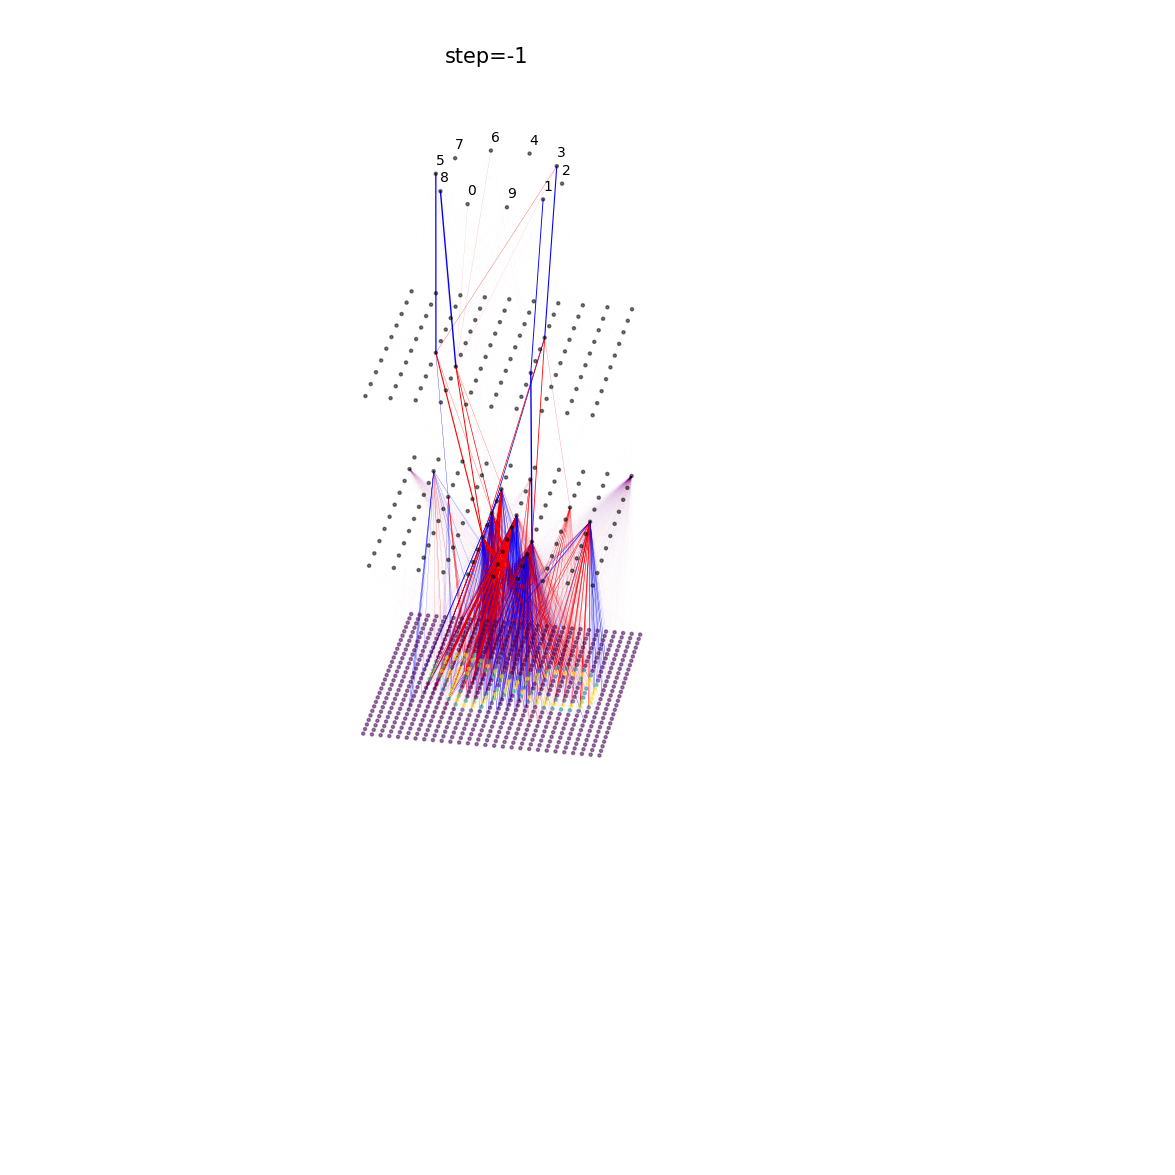

Average Logit Diff:  1.1036710809517025
iter:  0
iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000
iter:  1100
iter:  1200
iter:  1300
iter:  1400
iter:  1500
iter:  1600
iter:  1700
iter:  1800
iter:  1900
iter:  2000
iter:  2100
iter:  2200
iter:  2300
iter:  2400
iter:  2500
iter:  2600
iter:  2700
iter:  2800
iter:  2900
iter:  3000
iter:  3100
iter:  3200
iter:  3300
iter:  3400
iter:  3500
iter:  3600
iter:  3700
iter:  3800
iter:  3900
iter:  4000
iter:  4100
iter:  4200
iter:  4300
iter:  4400
iter:  4500
iter:  4600
iter:  4700
iter:  4800
iter:  4900
iter:  5000
iter:  5100
iter:  5200
iter:  5300
iter:  5400
iter:  5500
iter:  5600
iter:  5700
iter:  5800
iter:  5900
iter:  6000
iter:  6100
iter:  6200
iter:  6300
iter:  6400
iter:  6500
iter:  6600
iter:  6700
iter:  6800
iter:  6900
iter:  7000
iter:  7100
iter:  7200
iter:  7300
iter:  7400
iter:  7500
iter:  7600
iter:  7700
iter:  7800
iter:  7900
iter:  8000


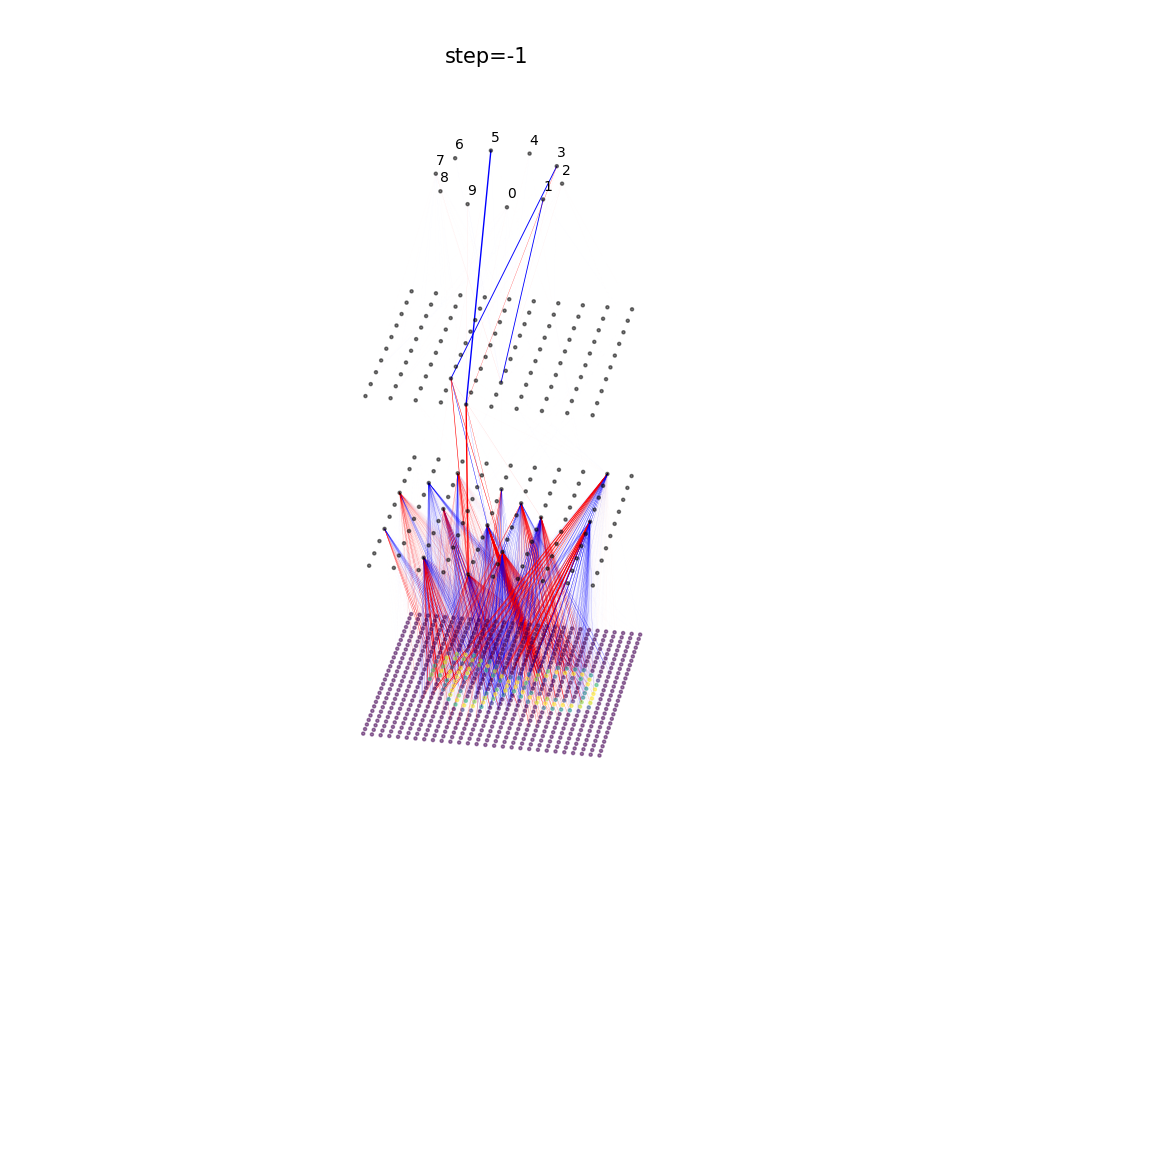

Average Logit Diff:  2.397877947860275
iter:  0
iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000
iter:  1100
iter:  1200
iter:  1300
iter:  1400
iter:  1500
iter:  1600
iter:  1700
iter:  1800
iter:  1900
iter:  2000
iter:  2100
iter:  2200
iter:  2300
iter:  2400
iter:  2500
iter:  2600
iter:  2700
iter:  2800
iter:  2900
iter:  3000
iter:  3100
iter:  3200
iter:  3300
iter:  3400
iter:  3500
iter:  3600
iter:  3700
iter:  3800
iter:  3900
iter:  4000
iter:  4100
iter:  4200
iter:  4300
iter:  4400
iter:  4500
iter:  4600
iter:  4700
iter:  4800
iter:  4900
iter:  5000
iter:  5100
iter:  5200
iter:  5300
iter:  5400
iter:  5500
iter:  5600
iter:  5700
iter:  5800
iter:  5900
iter:  6000
iter:  6100
iter:  6200
iter:  6300
iter:  6400
iter:  6500
iter:  6600
iter:  6700
iter:  6800
iter:  6900
iter:  7000
iter:  7100
iter:  7200
iter:  7300
iter:  7400
iter:  7500
iter:  7600
iter:  7700
iter:  7800
iter:  7900
iter:  8000
i

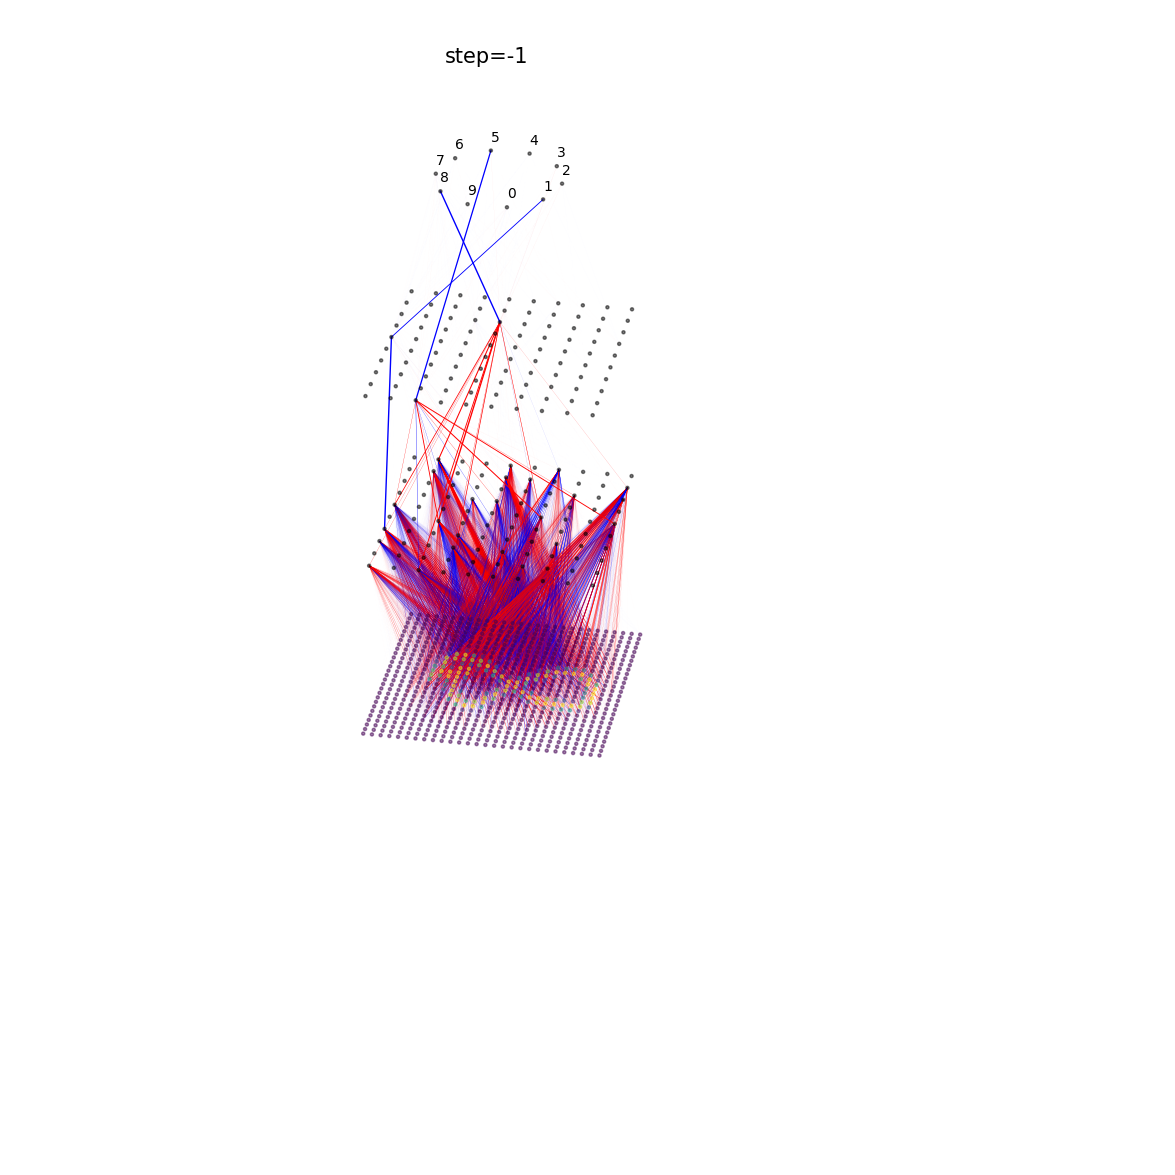

Average Logit Diff:  1.2855709542495888
iter:  0
iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000
iter:  1100
iter:  1200
iter:  1300
iter:  1400
iter:  1500
iter:  1600
iter:  1700
iter:  1800
iter:  1900
iter:  2000
iter:  2100
iter:  2200
iter:  2300
iter:  2400
iter:  2500
iter:  2600
iter:  2700
iter:  2800
iter:  2900
iter:  3000
iter:  3100
iter:  3200
iter:  3300
iter:  3400
iter:  3500
iter:  3600
iter:  3700
iter:  3800
iter:  3900
iter:  4000
iter:  4100
iter:  4200
iter:  4300
iter:  4400
iter:  4500
iter:  4600
iter:  4700
iter:  4800
iter:  4900
iter:  5000
iter:  5100
iter:  5200
iter:  5300
iter:  5400
iter:  5500
iter:  5600
iter:  5700
iter:  5800
iter:  5900
iter:  6000
iter:  6100
iter:  6200
iter:  6300
iter:  6400
iter:  6500
iter:  6600
iter:  6700
iter:  6800
iter:  6900
iter:  7000
iter:  7100
iter:  7200
iter:  7300
iter:  7400
iter:  7500
iter:  7600
iter:  7700
iter:  7800
iter:  7900
iter:  8000


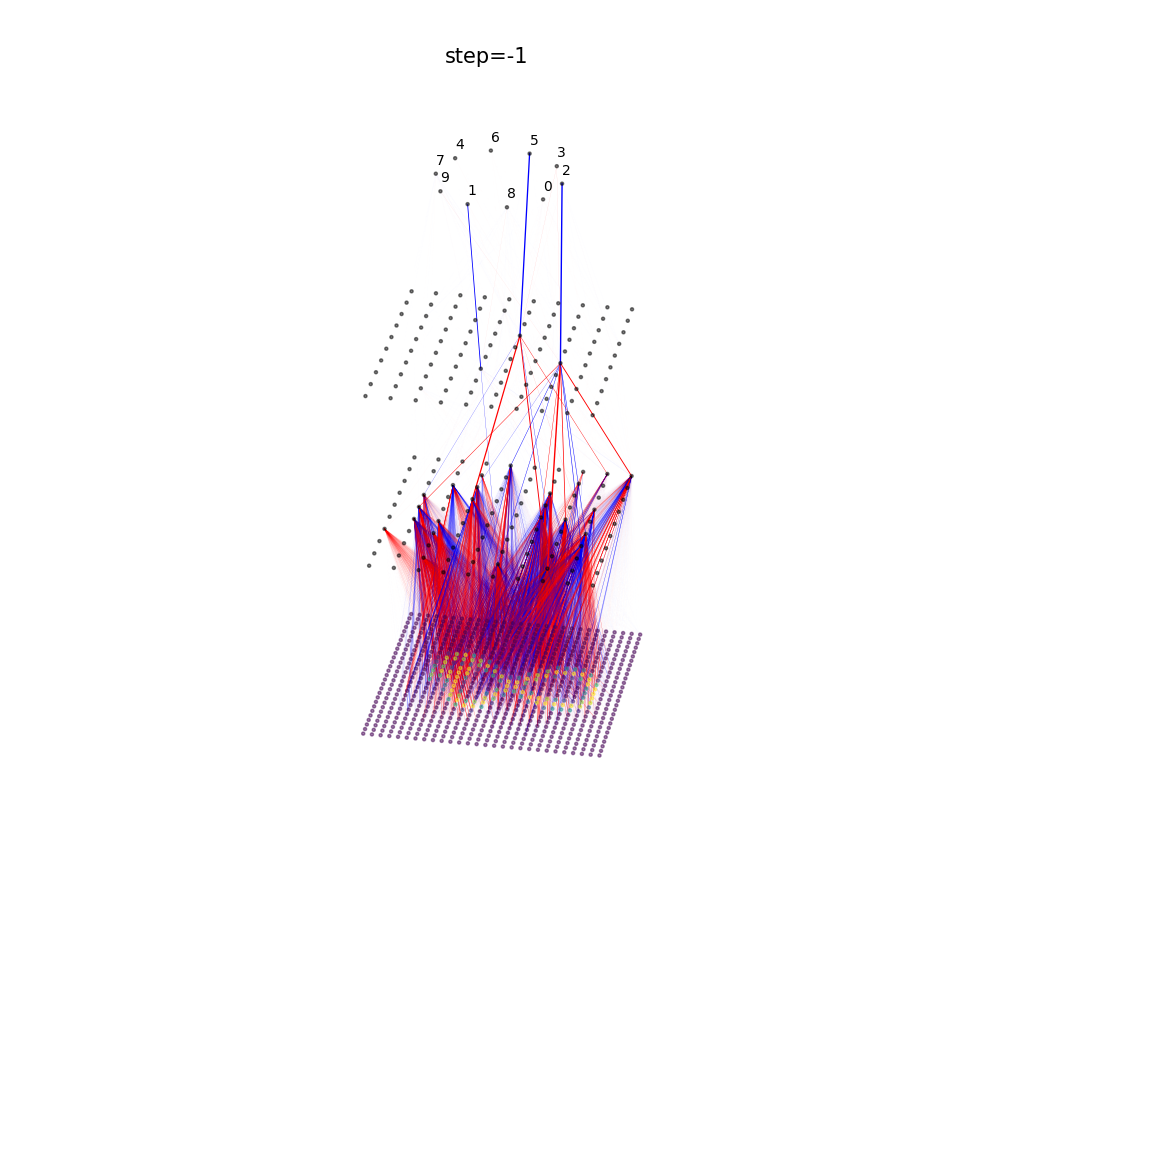

Average Logit Diff:  1.6702500199006753
iter:  0
iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000
iter:  1100
iter:  1200
iter:  1300
iter:  1400
iter:  1500
iter:  1600
iter:  1700
iter:  1800
iter:  1900
iter:  2000
iter:  2100
iter:  2200
iter:  2300
iter:  2400
iter:  2500
iter:  2600
iter:  2700
iter:  2800
iter:  2900
iter:  3000
iter:  3100
iter:  3200
iter:  3300
iter:  3400
iter:  3500
iter:  3600
iter:  3700
iter:  3800
iter:  3900
iter:  4000
iter:  4100
iter:  4200
iter:  4300
iter:  4400
iter:  4500
iter:  4600
iter:  4700
iter:  4800
iter:  4900
iter:  5000
iter:  5100
iter:  5200
iter:  5300
iter:  5400
iter:  5500
iter:  5600
iter:  5700
iter:  5800
iter:  5900
iter:  6000
iter:  6100
iter:  6200
iter:  6300
iter:  6400
iter:  6500
iter:  6600
iter:  6700
iter:  6800
iter:  6900
iter:  7000
iter:  7100
iter:  7200
iter:  7300
iter:  7400
iter:  7500
iter:  7600
iter:  7700
iter:  7800
iter:  7900
iter:  8000


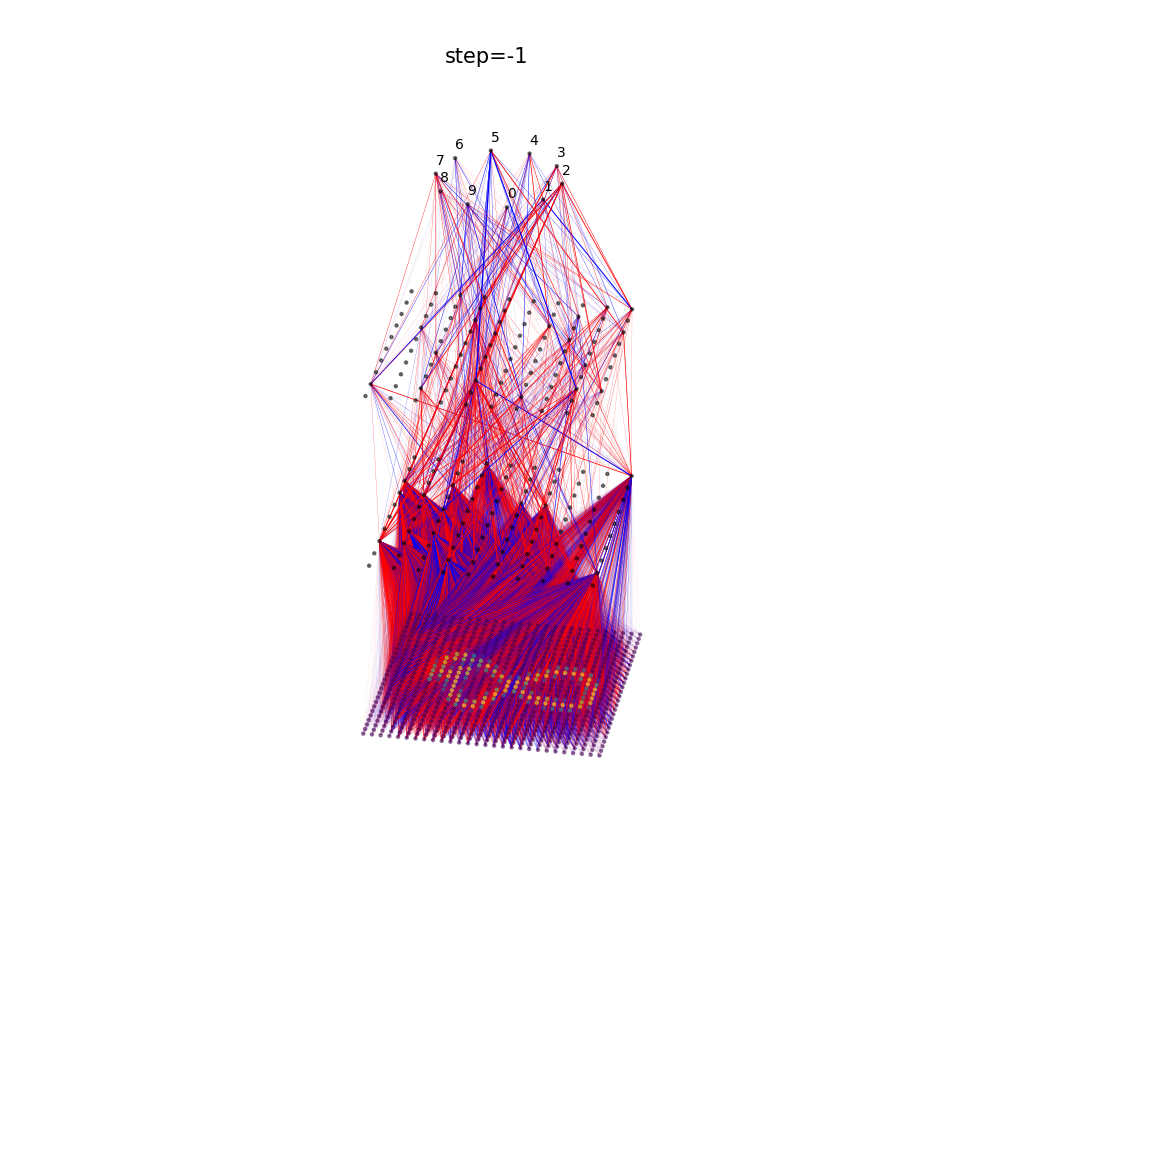

Average Logit Diff:  14.15476209648625


In [132]:
models = ["fivemodels/bimt.pt", "fivemodels/l1local.pt", "fivemodels/l1only.pt", "fivemodels/l1swap.pt", "fivemodels/fully_dense.pt"]

model_result = {}
for val, model in enumerate(models):
    mlp = BioMLP2D(shp=(784,100,100,10)).to("cpu")
    mlp.load_state_dict(torch.load(model))

    value_dict = defaultdict(lambda: {'sum': 0, 'count': 0})
    start = time.time()
    for i, (image1, image2) in enumerate(final_loader):
        sorted_neurons =  circuit_discovery(mlp, image2, image1)
        for layer, neuron, value in sorted_neurons:
            value_dict[(layer, neuron)]['sum'] += value
            value_dict[(layer, neuron)]['count'] += 1
        if i % 100 == 0:
            print("iter: ", i)

    average_values = {}
    for key, data in value_dict.items():
        average = data['sum'] / data['count']
        average_values[key] = average

    # print(average_values.items())

    data = average_values
    # Separate the dictionary for each layer and sort according to the logit value
    layer_dict = {}
    for (layer, neuron), logit in data.items():
        if layer not in layer_dict:
            layer_dict[layer] = []
        layer_dict[layer].append(((layer, neuron), logit))

    # Sort each layer's list by logit value in descending order
    for layer in layer_dict:
        layer_dict[layer].sort(key=lambda x: x[1], reverse=False)

    # stop = 
    top_15 = get_top_n_from_each_layer(layer_dict, 25)
    # model_result[val] = top_15
    stop_time = time.time()-start
    print("Model: ", model)
    print("Time to discover circuit: ", time.time()-start)
    for key, group in layer_dict.items():
        x_values = [t[0][1] for t in group]
        y_values = [t[1] for t in group]
        
        colors = ['Potentially Part of Circuit' if y < np.median(y_values) else 'Not relevant to task' for y in y_values]
        if key == 2:
            colors = ['Potentially Part of Circuit' if y <= np.median(y_values) else 'Not relevant to task' for y in y_values]
        if key == 1:
            colors = ['Potentially Part of Circuit' if y <= np.median(y_values) else 'Not relevant to task' for y in y_values]
        fig = px.scatter(x = x_values, y=y_values, color=colors) #, size=[0.001]*len(x_values))
        fig.update_traces(marker=dict(
            size=15,
            line=dict(
                width=1,
                color='DarkSlateGrey'
            )
        ))
        fig.update_xaxes(title_text='Neuron (i)')
        fig.update_yaxes(title_text='Logit Difference (L_corr --> L_clean)')
        fig.update_layout(width=1000, height=700)
        # fig.write_image(f"fivemodelresults/neuron_{val}_{key}_plot.png")
        fig.show()
    

    fig=plt.figure(figsize=(30,15))
    ax=fig.add_subplot(projection='3d')

    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
    ax.scatter(mlp.linears[0].in_coordinates[:,0].detach().numpy(), mlp.linears[0].in_coordinates[:,1].detach().numpy(),[0]*784, s=5, alpha=0.5, c=train[46][0][0].detach().numpy()[:,::-1].reshape(-1,))
    ax.scatter(mlp.linears[1].in_coordinates[:,0].detach().numpy(), mlp.linears[1].in_coordinates[:,1].detach().numpy(),[1]*100, s=5, alpha=0.5, color="black")
    ax.scatter(mlp.linears[2].in_coordinates[:,0].detach().numpy(), mlp.linears[2].in_coordinates[:,1].detach().numpy(),[2]*100, s=5, alpha=0.5, color="black")
    ax.scatter(mlp.linears[2].out_coordinates[:,0].detach().numpy(), mlp.linears[2].out_coordinates[:,1].detach().numpy(),[3]*10, s=5, alpha=0.5, color="black")
    ax.set_zlim(-0.5,5)
    ax.set_xlim(-0.2,1.2)
    ax.set_ylim(-0.2,1.2)


    for ii in range(3):
        biolinear = mlp.linears[ii]
        p = biolinear.linear.weight.clone()
        if ii == 0:
            p = sparsify2circuit_left(p, torch.tensor(top_15[ii]))
            
        elif ii == 2:
            p = sparsify2circuit_right(p, torch.tensor(top_15[ii-1]))
            # print("okau")
        else:
            p = sparsify2circuit_right(p, torch.tensor(top_15[ii-1]))
            p = sparsify2circuit_left(p, torch.tensor(top_15[ii]))
        p_shp = p.shape
        p = p/torch.abs(p).max()

        for i in range(p_shp[0]):
            # if i % 20 == 0:
            #     print(i)
            for j in range(p_shp[1]):
                out_xy = biolinear.out_coordinates[i].detach().cpu().numpy()
                in_xy = biolinear.in_coordinates[j].detach().cpu().numpy()
                plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")


    ring = mlp.linears[2].out_coordinates.detach().cpu().numpy()
    for i in range(10):
        ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(mlp.out_perm.long()[i].detach().cpu().numpy()))


    ax.view_init(30,10)

    ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

    ax.axis('off') 

    # plt.savefig('fivemodelresults/circuit_{}.png'.format(val))

    plt.show()

    avg_logit_diff = 0
    for i, (image1, image2) in enumerate(final_loader):
        clean_tensor = image2
        mlp.eval()
        with torch.no_grad():
            og_op = mlp(clean_tensor)
            clean_activations = activations.copy()

        sub_graph_act = [a.clone() for a in clean_activations]

        for inn_idx, sub_layer in enumerate(mlp.get_linear_layers()[1:]):
            # print(inn_idx+layer_idx)
            zero_tensor = torch.zeros_like(sub_graph_act[inn_idx])
            zero_tensor[0, torch.tensor(top_15[inn_idx])] = sub_graph_act[inn_idx][0, torch.tensor(top_15[inn_idx])]
            sub_graph_act[inn_idx] = zero_tensor
            # print(sub_graph_act[inn_idx].shape)
            sub_graph_act[inn_idx+1] = sub_layer(sub_graph_act[inn_idx])

        avg_logit_diff += measure_improvement(sub_graph_act[-1], og_op)
        # break
    avg_logit_diff = avg_logit_diff/len(final_loader)
    print("Average Logit Diff: ", avg_logit_diff)
    model_result[val] = [top_15, avg_logit_diff, stop_time]
    

In [134]:
model_result

{0: [{2: [7, 3, 6, 2, 0, 9, 5, 1, 4, 8],
   1: [63,
    25,
    66,
    36,
    23,
    75,
    39,
    47,
    93,
    31,
    18,
    98,
    71,
    35,
    30,
    37,
    9,
    58,
    32,
    29,
    96,
    90,
    7,
    91,
    0],
   0: [55,
    44,
    54,
    42,
    66,
    67,
    46,
    51,
    73,
    23,
    84,
    11,
    50,
    71,
    48,
    68,
    58,
    13,
    9,
    89,
    1,
    59,
    19,
    92,
    90]},
  1.1036710809517025,
  562.970832824707],
 1: [{2: [5, 3, 2, 9, 7, 4, 1, 0, 8, 6],
   1: [49,
    37,
    57,
    8,
    29,
    42,
    84,
    7,
    25,
    61,
    1,
    92,
    91,
    89,
    90,
    33,
    52,
    38,
    97,
    21,
    19,
    75,
    68,
    14,
    53],
   0: [28,
    45,
    49,
    80,
    53,
    64,
    84,
    57,
    3,
    12,
    24,
    21,
    6,
    42,
    43,
    0,
    4,
    97,
    76,
    44,
    32,
    35,
    78,
    52,
    69]},
  2.397877947860275,
  602.9912509918213],
 2: [{2: [3, 5, 7, 2, 9, 0

In [102]:
for key, group in layer_dict.items():
    x_values = [t[0][1] for t in group]
    y_values = [t[1] for t in group]
    
    colors = ['Potentially Part of Circuit' if y < np.median(y_values) else 'Not relevant to task' for y in y_values]
    if key == 2:
        colors = ['Potentially Part of Circuit' if y <= np.median(y_values) else 'Not relevant to task' for y in y_values]
    if key == 1:
        colors = ['Potentially Part of Circuit' if y <= np.median(y_values) else 'Not relevant to task' for y in y_values]
    fig = px.scatter(x = x_values, y=y_values, color=colors) #, size=[0.001]*len(x_values))
    fig.update_traces(marker=dict(
        size=15,
        line=dict(
            width=1,
            color='DarkSlateGrey'
        )
    ))
    fig.update_xaxes(title_text='Neuron (i)')
    fig.update_yaxes(title_text='Logit Difference (L_corr --> L_clean)')
    fig.update_layout(width=1000, height=700)
    fig.write_image(f"fivemodelresults/neuron_{val}_{key}_plot.png")
    # fig.show()

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [ ]:

fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
ax.scatter(mlp.linears[0].in_coordinates[:,0].detach().numpy(), mlp.linears[0].in_coordinates[:,1].detach().numpy(),[0]*784, s=5, alpha=0.5, c=train[46][0][0].detach().numpy()[:,::-1].reshape(-1,))
ax.scatter(mlp.linears[1].in_coordinates[:,0].detach().numpy(), mlp.linears[1].in_coordinates[:,1].detach().numpy(),[1]*100, s=5, alpha=0.5, color="black")
ax.scatter(mlp.linears[2].in_coordinates[:,0].detach().numpy(), mlp.linears[2].in_coordinates[:,1].detach().numpy(),[2]*100, s=5, alpha=0.5, color="black")
ax.scatter(mlp.linears[2].out_coordinates[:,0].detach().numpy(), mlp.linears[2].out_coordinates[:,1].detach().numpy(),[3]*10, s=5, alpha=0.5, color="black")
ax.set_zlim(-0.5,5)
ax.set_xlim(-0.2,1.2)
ax.set_ylim(-0.2,1.2)


for ii in range(3):
    biolinear = mlp.linears[ii]
    p = biolinear.linear.weight.clone()
    if ii == 0:
        p = sparsify2circuit_left(p, torch.tensor(top_15[ii]))
        
    elif ii == 2:
        p = sparsify2circuit_right(p, torch.tensor(top_15[ii-1]))
        print("okau")
    else:
        p = sparsify2circuit_right(p, torch.tensor(top_15[ii-1]))
        p = sparsify2circuit_left(p, torch.tensor(top_15[ii]))
    p_shp = p.shape
    p = p/torch.abs(p).max()

    for i in range(p_shp[0]):
        if i % 20 == 0:
            print(i)
        for j in range(p_shp[1]):
            out_xy = biolinear.out_coordinates[i].detach().cpu().numpy()
            in_xy = biolinear.in_coordinates[j].detach().cpu().numpy()
            plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")


ring = mlp.linears[2].out_coordinates.detach().cpu().numpy()
for i in range(10):
    ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(mlp.out_perm.long()[i].detach().cpu().numpy()))


ax.view_init(30,10)

ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

ax.axis('off') 

# plt.savefig('./results/mnist_noswap/{0:06d}.png'.format(step-1))

plt.show()

In [ ]:

avg_logit_diff = 0
for i, (image1, image2) in enumerate(loader_3_8):
    clean_tensor = image2
    mlp.eval()
    with torch.no_grad():
        og_op = mlp(clean_tensor)
        clean_activations = activations.copy()

    sub_graph_act = [a.clone() for a in clean_activations]

    for inn_idx, sub_layer in enumerate(mlp.get_linear_layers()[1:]):
        # print(inn_idx+layer_idx)
        zero_tensor = torch.zeros_like(sub_graph_act[inn_idx])
        zero_tensor[0, torch.tensor(top_15[inn_idx])] = sub_graph_act[inn_idx][0, torch.tensor(top_15[inn_idx])]
        sub_graph_act[inn_idx] = zero_tensor
        # print(sub_graph_act[inn_idx].shape)
        sub_graph_act[inn_idx+1] = sub_layer(sub_graph_act[inn_idx])

    avg_logit_diff += measure_improvement(sub_graph_act[-1], og_op)
    # break
avg_logit_diff = avg_logit_diff/len(loader_3_8)
print(avg_logit_diff)



# Sparsity Calculation

In [121]:
model_result = {0: [{2: [7, 0, 8, 5, 6, 2, 3, 9, 4, 1],
   1: [63, 66, 40, 23, 37, 61, 1, 65, 32, 69, 68, 58, 18, 35, 62],
   0: [55, 54, 67, 66, 46, 23, 51, 44, 73, 71, 48, 5, 89, 50, 49]},
  0.9723076512344735,
  223.0387668609619],
 1: [{2: [9, 3, 0, 2, 8, 1, 4, 7, 5, 6],
   1: [35, 57, 24, 33, 25, 42, 55, 90, 1, 7, 51, 63, 14, 84, 50],
   0: [47, 49, 28, 80, 12, 38, 64, 53, 84, 3, 18, 14, 46, 42, 24]},
  1.1244407398545462,
  232.1004250049591],
 2: [{2: [3, 9, 8, 0, 4, 7, 2, 1, 5, 6],
   1: [54, 32, 35, 75, 60, 74, 81, 91, 98, 89, 93, 28, 38, 26, 37],
   0: [91, 36, 41, 29, 72, 76, 43, 13, 83, 10, 64, 37, 60, 78, 7]},
  0.9640563154513052,
  240.2496349811554],
 3: [{2: [4, 3, 5, 8, 0, 7, 1, 2, 9, 6],
   1: [63, 22, 99, 51, 94, 61, 72, 1, 67, 55, 86, 70, 28, 83, 11],
   0: [78, 74, 15, 25, 55, 33, 63, 41, 22, 85, 52, 64, 90, 23, 62]},
  1.319244285710424,
  248.98452615737915],
 4: [{2: [3, 9, 8, 2, 0, 7, 1, 4, 5, 6],
   1: [8, 48, 31, 46, 90, 20, 85, 30, 24, 13, 11, 0, 80, 43, 34],
   0: [78, 48, 16, 90, 24, 57, 63, 22, 95, 49, 13, 18, 30, 66, 37]},
  6.675144498934497,
  258.0258560180664]}

In [122]:
model_result[0][0][0]

[55, 54, 67, 66, 46, 23, 51, 44, 73, 71, 48, 5, 89, 50, 49]

In [130]:
models = ["fivemodels/bimt.pt", "fivemodels/l1local.pt", "fivemodels/l1only.pt", "fivemodels/l1swap.pt", "fivemodels/fully_dense.pt"]

# model_result = {}
for val, model in enumerate(models):
    mlp = BioMLP2D(shp=(784,100,100,10)).to("cpu")
    mlp.load_state_dict(torch.load(model))
    avg_spar = 0
    for ii in range(3):
        biolinear = mlp.linears[ii]
        p = biolinear.linear.weight.clone()
        # if ii == 0:
        #     p = sparsify2circuit_left(p, torch.tensor(model_result[val][0][ii]))
        # else:
        #     p = sparsify2circuit_right(p, torch.tensor(model_result[val][0][ii]))
        #     p = sparsify2circuit_left(p, torch.tensor(model_result[val][0][ii]))
        
        # print(p.T.shape)
        W = p.T.detach().numpy()
        # print(np.mean(np.abs(W)))
        #     # W = linears[ii].linear.weight.T.detach().numpy()
        n_sparsity = (np.abs(W)<0.0009).sum()
        avg_spar+=n_sparsity/(W.shape[0]*W.shape[1])
        # print("Percentage Sparsity:", n_sparsity/(W.shape[0]*W.shape[1]))
    avg_spar = avg_spar/3
    print(f"Average Sparsity for {models[val]}: {avg_spar}")
    # print("New model start")

torch.Size([784, 100])
torch.Size([100, 100])
torch.Size([100, 10])
Average Sparsity for fivemodels/bimt.pt: 0.920823299319728
torch.Size([784, 100])
torch.Size([100, 100])
torch.Size([100, 10])
Average Sparsity for fivemodels/l1local.pt: 0.9157727891156463
torch.Size([784, 100])
torch.Size([100, 100])
torch.Size([100, 10])
Average Sparsity for fivemodels/l1only.pt: 0.8697651360544217
torch.Size([784, 100])
torch.Size([100, 100])
torch.Size([100, 10])
Average Sparsity for fivemodels/l1swap.pt: 0.8711826530612244
torch.Size([784, 100])
torch.Size([100, 100])
torch.Size([100, 10])
Average Sparsity for fivemodels/fully_dense.pt: 0.008590816326530613


# More testing, return back to above this

In [ ]:
# Sort each layer's list by logit value in descending order
for layer in layer_dict:
    layer_dict[layer].sort(key=lambda x: x[1], reverse=False)
    
def get_top_n_from_each_layer(layer_dict, n):
    # top_n = {}
    top_try = {}
    for layer in layer_dict:
        # top_n[layer] = layer_dict[layer][:n]
        top_try[layer] = [z[0][1] for z in layer_dict[layer][:n]]
    return top_try

# # Example: Get top 5 elements from each layer
top_5 = get_top_n_from_each_layer(layer_dict, 15)
print(top_5)
# layer_dict

{2: [7, 9, 1, 5, 2, 0, 6, 4, 3, 8], 1: [46, 56, 68, 45, 80, 85, 0, 43, 24, 28, 92, 73, 13, 39, 62], 0: [78, 71, 48, 22, 2, 3, 67, 24, 90, 98, 63, 88, 37, 58, 57]}


In [ ]:
layer_dict

{2: [((2, 7), 1.3979081806057112),
  ((2, 9), 1.3979161536361473),
  ((2, 1), 1.3979412712382162),
  ((2, 5), 1.39794368854732),
  ((2, 2), 1.3979543809849184),
  ((2, 0), 1.397990075151567),
  ((2, 6), 1.3979911509639604),
  ((2, 4), 1.3979986693803683),
  ((2, 3), 1.39822773924446),
  ((2, 8), 1.398511574815795)],
 1: [((1, 46), 3.6182806019782205),
  ((1, 56), 3.6192124649676027),
  ((1, 68), 3.6203367677107363),
  ((1, 45), 3.62070188538027),
  ((1, 80), 3.621534498792044),
  ((1, 85), 3.6215433958472807),
  ((1, 0), 3.6218039895648366),
  ((1, 43), 3.62224075719243),
  ((1, 24), 3.6225753867347064),
  ((1, 28), 3.6228976189896627),
  ((1, 92), 3.6229094111232794),
  ((1, 73), 3.623022081902487),
  ((1, 13), 3.6232256960347256),
  ((1, 39), 3.6232310382652804),
  ((1, 62), 3.6232361264197035),
  ((1, 97), 3.6233287704559376),
  ((1, 8), 3.623353616210502),
  ((1, 31), 3.623394814093405),
  ((1, 71), 3.6236748834936625),
  ((1, 49), 3.6240177679990953),
  ((1, 20), 3.624044447979383

In [ ]:
for key, group in layer_dict.items():
    x_values = [t[0][1] for t in group]
    y_values = [t[1] for t in group]
    print(x_values)
    print(y_values)
    break

[7, 9, 1, 5, 2, 0, 6, 4, 3, 8]
[1.3979081806057112, 1.3979161536361473, 1.3979412712382162, 1.39794368854732, 1.3979543809849184, 1.397990075151567, 1.3979911509639604, 1.3979986693803683, 1.39822773924446, 1.398511574815795]


In [44]:
def get_top_n_from_each_layer(layer_dict, n):
    # top_n = {}
    top_try = {}
    for layer in layer_dict:
        # top_n[layer] = layer_dict[layer][:n]
        top_try[layer] = [z[0][1] for z in layer_dict[layer][:n]]
    return top_try

# # Example: Get top 5 elements from each layer

print(top_5)

def sparsify2circuit_left(wt_tensor, indices_tensor):
    zero_tensor = torch.zeros_like(wt_tensor)
    zero_tensor[indices_tensor, :] = wt_tensor[indices_tensor, :]
    return zero_tensor

def sparsify2circuit_right(wt_tensor, indices_tensor):
    zero_tensor = torch.zeros_like(wt_tensor)
    zero_tensor[:, indices_tensor] = wt_tensor[:, indices_tensor]
    return zero_tensor

In [66]:
model = "fivemodels/bimt.pt"
mlp = BioMLP2D(shp=(784,100,100,10)).to("cpu")
mlp.load_state_dict(torch.load(model))

value_dict = defaultdict(lambda: {'sum': 0, 'count': 0})
start = time.time()
for i, (image1, image2) in enumerate(loader_3_8):
    sorted_neurons =  circuit_discovery(mlp, image2, image1)
    for layer, neuron, value in sorted_neurons:
        value_dict[(layer, neuron)]['sum'] += value
        value_dict[(layer, neuron)]['count'] += 1
    if i % 100 == 0:
        print("iter: ", i)

average_values = {}
for key, data in value_dict.items():
    average = data['sum'] / data['count']
    average_values[key] = average

# print(average_values.items())

data = average_values
# Separate the dictionary for each layer and sort according to the logit value
layer_dict = {}
for (layer, neuron), logit in data.items():
    if layer not in layer_dict:
        layer_dict[layer] = []
    layer_dict[layer].append(((layer, neuron), logit))

# Sort each layer's list by logit value in descending order
for layer in layer_dict:
    layer_dict[layer].sort(key=lambda x: x[1], reverse=False)

# stop = 
top_15 = get_top_n_from_each_layer(layer_dict, 15)

print("Model: ", model)
print("Time to discover circuit: ", time.time()-start)

iter:  0
iter:  100
iter:  200
iter:  300
iter:  400
iter:  500
iter:  600
iter:  700
iter:  800
iter:  900
iter:  1000
iter:  1100
iter:  1200
iter:  1300
iter:  1400
iter:  1500
iter:  1600
iter:  1700
iter:  1800
iter:  1900
iter:  2000
iter:  2100
iter:  2200
iter:  2300
iter:  2400
iter:  2500
iter:  2600
iter:  2700
iter:  2800
iter:  2900
iter:  3000
iter:  3100
iter:  3200
iter:  3300
iter:  3400
iter:  3500
iter:  3600
iter:  3700
iter:  3800
iter:  3900
iter:  4000
iter:  4100
iter:  4200
iter:  4300
iter:  4400
iter:  4500
iter:  4600
iter:  4700
iter:  4800
iter:  4900
iter:  5000
iter:  5100
iter:  5200
iter:  5300
iter:  5400
iter:  5500
iter:  5600
iter:  5700
iter:  5800
Model:  fivemodels/bimt.pt
Time to discover circuit:  173.92311000823975


In [77]:
# layer_dict
top_15 = get_top_n_from_each_layer(layer_dict, 30)
top_15

{2: [6, 2, 7, 0, 9, 5, 1, 4, 3, 8],
 1: [74,
  66,
  82,
  96,
  26,
  58,
  18,
  10,
  11,
  40,
  81,
  22,
  15,
  61,
  62,
  59,
  12,
  90,
  56,
  71,
  9,
  19,
  21,
  54,
  30,
  84,
  80,
  72,
  1,
  88],
 0: [36,
  55,
  84,
  46,
  65,
  56,
  33,
  73,
  51,
  24,
  7,
  67,
  34,
  47,
  66,
  11,
  71,
  41,
  68,
  48,
  62,
  79,
  30,
  13,
  10,
  5,
  12,
  72,
  61,
  93]}

In [70]:
for key, group in layer_dict.items():
    x_values = [t[0][1] for t in group]
    y_values = [t[1] for t in group]
    
    colors = ['Potentially Part of Circuit' if y < np.median(y_values) else 'Not relevant to task' for y in y_values]
    if key == 2:
        colors = ['Potentially Part of Circuit' if y <= np.median(y_values) else 'Not relevant to task' for y in y_values]
    if key == 1:
        colors = ['Potentially Part of Circuit' if y <= np.median(y_values) else 'Not relevant to task' for y in y_values]
    fig = px.scatter(x = x_values, y=y_values, color=colors) #, size=[0.001]*len(x_values))
    fig.update_traces(marker=dict(
        size=15,
        line=dict(
            width=1,
            color='DarkSlateGrey'
        )
    ))
    fig.update_xaxes(title_text='Neuron (i)')
    fig.update_yaxes(title_text='Logit Difference (L_corr --> L_clean)')
    fig.update_layout(width=1000, height=700)
    fig.show()

In [86]:
for ii in reversed(range(3)):
    biolinear = mlp.linears[ii]
    p = biolinear.linear.weight.clone()
    # p = sparsify2circuit_right(p, torch.tensor(top_15[ii-1]))
    # p = sparsify2circuit_left(p, torch.tensor(top_15[ii]))
    print(p.shape)

torch.Size([10, 100])
torch.Size([100, 100])
torch.Size([100, 784])


In [81]:
top_15

{2: [6, 2, 7, 0, 9, 5, 1, 4, 3, 8],
 1: [74,
  66,
  82,
  96,
  26,
  58,
  18,
  10,
  11,
  40,
  81,
  22,
  15,
  61,
  62,
  59,
  12,
  90,
  56,
  71,
  9,
  19,
  21,
  54,
  30,
  84,
  80,
  72,
  1,
  88],
 0: [36,
  55,
  84,
  46,
  65,
  56,
  33,
  73,
  51,
  24,
  7,
  67,
  34,
  47,
  66,
  11,
  71,
  41,
  68,
  48,
  62,
  79,
  30,
  13,
  10,
  5,
  12,
  72,
  61,
  93]}

0
20
40
60
80
0
20
40
60
80
okau
0


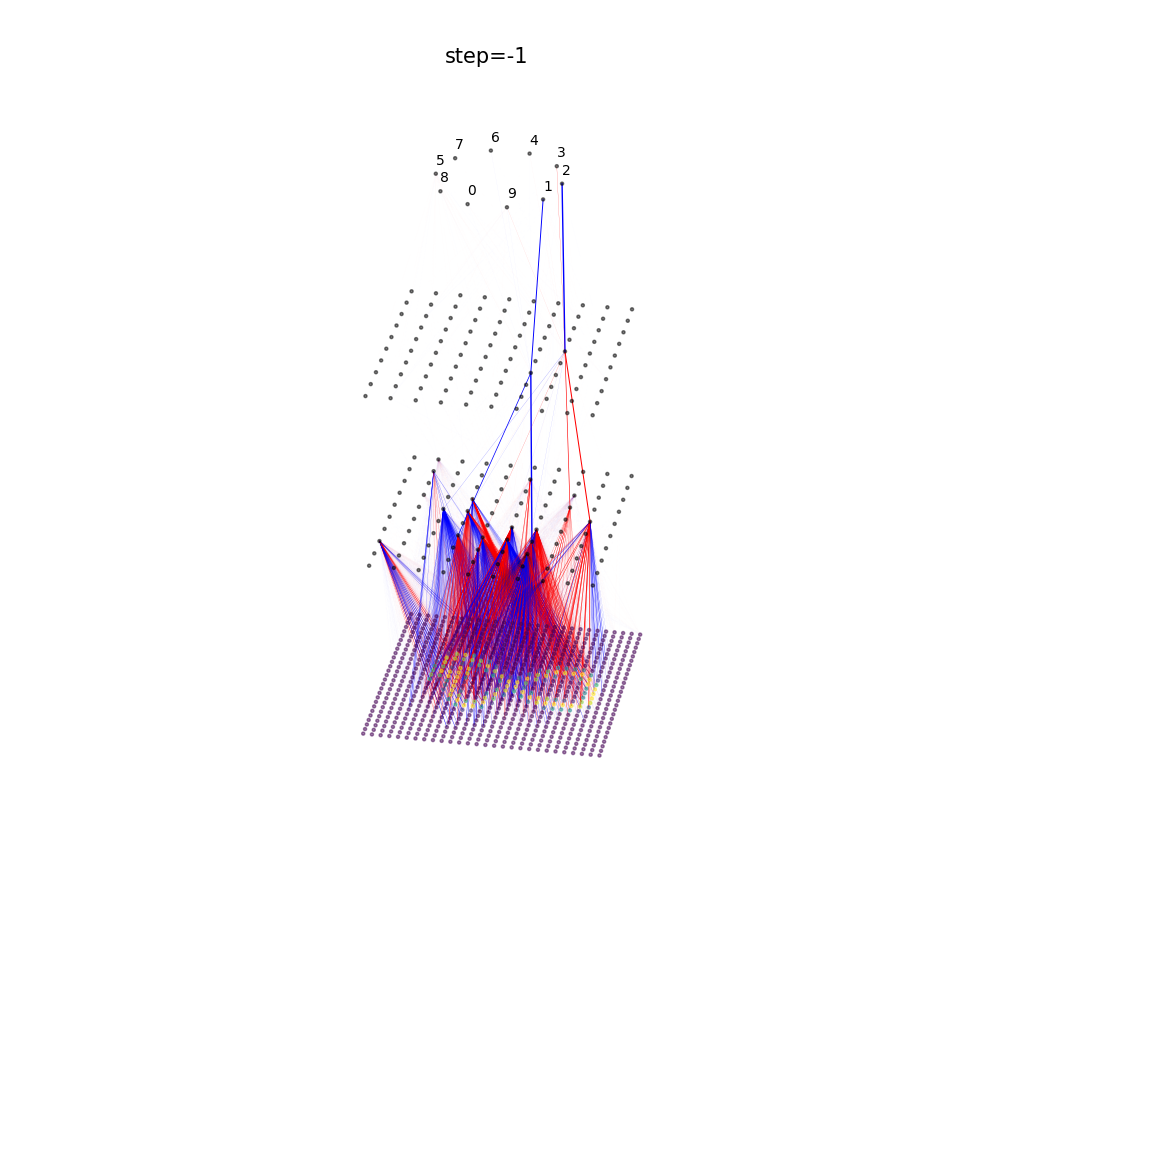

In [91]:

fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(projection='3d')

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 0.5, 2, 1]))
ax.scatter(mlp.linears[0].in_coordinates[:,0].detach().numpy(), mlp.linears[0].in_coordinates[:,1].detach().numpy(),[0]*784, s=5, alpha=0.5, c=train[46][0][0].detach().numpy()[:,::-1].reshape(-1,))
ax.scatter(mlp.linears[1].in_coordinates[:,0].detach().numpy(), mlp.linears[1].in_coordinates[:,1].detach().numpy(),[1]*100, s=5, alpha=0.5, color="black")
ax.scatter(mlp.linears[2].in_coordinates[:,0].detach().numpy(), mlp.linears[2].in_coordinates[:,1].detach().numpy(),[2]*100, s=5, alpha=0.5, color="black")
ax.scatter(mlp.linears[2].out_coordinates[:,0].detach().numpy(), mlp.linears[2].out_coordinates[:,1].detach().numpy(),[3]*10, s=5, alpha=0.5, color="black")
ax.set_zlim(-0.5,5)
ax.set_xlim(-0.2,1.2)
ax.set_ylim(-0.2,1.2)


for ii in range(3):
    biolinear = mlp.linears[ii]
    p = biolinear.linear.weight.clone()
    if ii == 0:
        p = sparsify2circuit_left(p, torch.tensor(top_15[ii]))
        
    elif ii == 2:
        p = sparsify2circuit_right(p, torch.tensor(top_15[ii-1]))
        print("okau")
    else:
        p = sparsify2circuit_right(p, torch.tensor(top_15[ii-1]))
        p = sparsify2circuit_left(p, torch.tensor(top_15[ii]))
    p_shp = p.shape
    p = p/torch.abs(p).max()

    for i in range(p_shp[0]):
        if i % 20 == 0:
            print(i)
        for j in range(p_shp[1]):
            out_xy = biolinear.out_coordinates[i].detach().cpu().numpy()
            in_xy = biolinear.in_coordinates[j].detach().cpu().numpy()
            plt.plot([out_xy[0], in_xy[0]], [out_xy[1], in_xy[1]], [ii+1,ii], lw=1*np.abs(p[i,j].detach().cpu().numpy()), color="blue" if p[i,j]>0 else "red")


ring = mlp.linears[2].out_coordinates.detach().cpu().numpy()
for i in range(10):
    ax.text(ring[i,0], ring[i,1], 3.05, "{}".format(mlp.out_perm.long()[i].detach().cpu().numpy()))


ax.view_init(30,10)

ax.text(0.3,0.25,3.5,"step={}".format(step-1), fontsize=15)

ax.axis('off') 

# plt.savefig('./results/mnist_noswap/{0:06d}.png'.format(step-1))

plt.show()

In [72]:
for i, (image1, image2) in enumerate(loader_3_8):
    clean_tensor = image2
    break

In [73]:
clean_tensor.shape

torch.Size([1, 1, 28, 28])

In [94]:
len(loader_3_8)

5851

In [96]:

avg_logit_diff = 0
for i, (image1, image2) in enumerate(loader_3_8):
    clean_tensor = image2
    mlp.eval()
    with torch.no_grad():
        og_op = mlp(clean_tensor)
        clean_activations = activations.copy()

    sub_graph_act = [a.clone() for a in clean_activations]

    for inn_idx, sub_layer in enumerate(mlp.get_linear_layers()[1:]):
        # print(inn_idx+layer_idx)
        zero_tensor = torch.zeros_like(sub_graph_act[inn_idx])
        zero_tensor[0, torch.tensor(top_15[inn_idx])] = sub_graph_act[inn_idx][0, torch.tensor(top_15[inn_idx])]
        sub_graph_act[inn_idx] = zero_tensor
        # print(sub_graph_act[inn_idx].shape)
        sub_graph_act[inn_idx+1] = sub_layer(sub_graph_act[inn_idx])

    avg_logit_diff += measure_improvement(sub_graph_act[-1], og_op)
    # break
avg_logit_diff = avg_logit_diff/len(loader_3_8)
print(avg_logit_diff)



1.192979402525611


In [76]:
sub_graph_act[-1]

tensor([[-2.4541e-02, -3.0837e-01,  7.8346e-01, -8.5549e-02, -5.7175e-03,
         -4.4596e-03, -2.0066e-05,  1.3330e-03, -5.0189e-04, -3.7738e-03]],
       grad_fn=<AddmmBackward0>)

In [75]:
measure_improvement(sub_graph_act[-1], og_op)

1.2938936948776245